<a href="https://colab.research.google.com/github/Mrunali0412/Deep-DPD-modelling-for-PA-Linearization/blob/main/Comparision_DPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN DPD

Using device: cuda
Deep Learning DPD for PA Linearization

Training NN-PA on 22288 samples...
Epoch [20/100], Train Loss: 0.005277, Val Loss: 0.000588
Epoch [40/100], Train Loss: 0.004531, Val Loss: 0.000599
Epoch [60/100], Train Loss: 0.004310, Val Loss: 0.000471
Epoch [80/100], Train Loss: 0.004108, Val Loss: 0.000240
Epoch [100/100], Train Loss: 0.004091, Val Loss: 0.000261
NN-PA training complete.
NN-PA NMSE vs real PA: -28.12 dB

--- Performance Physical PA ---
NMSE: -10.58 dB
EVM: 26.47 %
ACPR: -43.01 dB

--- Performance NN-PA ---
NMSE: -11.57 dB
EVM: 23.81 %
ACPR: -37.11 dB

[3] Training Deep Learning DPD...
Epoch [20/100] Train Loss: 0.001512, Val Loss: 0.001056
Epoch [40/100] Train Loss: 0.001184, Val Loss: 0.000825
Epoch [60/100] Train Loss: 0.001094, Val Loss: 0.000727
Epoch [80/100] Train Loss: 0.001025, Val Loss: 0.000584
Epoch [100/100] Train Loss: 0.001003, Val Loss: 0.000555

--- Performance WITH Deep DPD ---
NMSE: -21.08 dB
EVM: 8.47 %
ACPR: -31.79 dB

--- IMPROVEMENT 

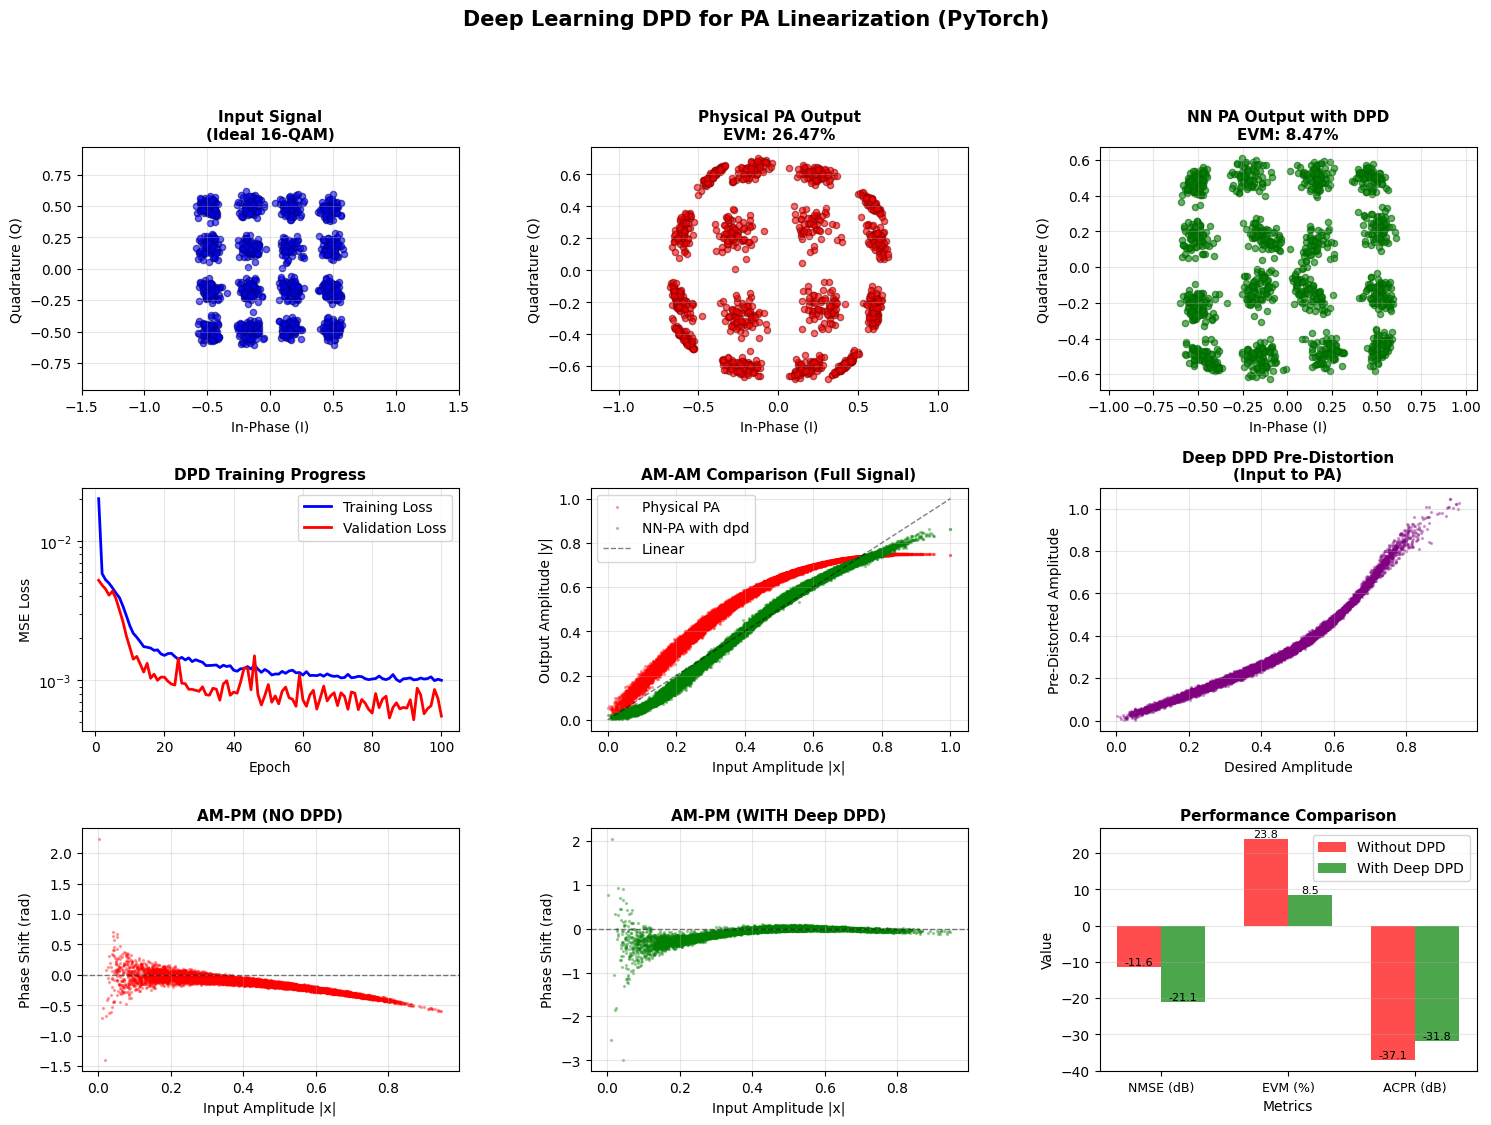


Simulation Complete!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import upfirdn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Global constants for model configuration
HIDDEN_DIMS=[128,64,32]
DROPOUT = 0.2

# ==========================================
# 1. 16-QAM Signal Generator
# ==========================================
def generate_realistic_16qam(num_symbols, sps, rolloff):
    """Generates a clean 16-QAM signal with RRC pulse shaping."""
    # 1. Create 16-QAM Constellation Map (4x4 grid)
    qam_map = np.array([x + 1j*y for x in range(-3, 4, 2) for y in range(-3, 4, 2)])
    qam_map /= np.sqrt(np.mean(np.abs(qam_map)**2))  # Normalize power

    # 2. Random Symbols
    symbols_idx = np.random.randint(0, 16, num_symbols)
    symbols = qam_map[symbols_idx]

    # 3. RRC Pulse Shaping
    span = 10
    num_taps = span * sps + 1
    t = np.arange(num_taps) - (num_taps - 1) // 2

    # RRC filter design
    h_rrc = np.zeros(num_taps)
    for i in range(num_taps):
        t_val = t[i] / float(sps)

        if t_val == 0.0:
            h_rrc[i] = 1.0 - rolloff + (4.0 * rolloff / np.pi)
        elif rolloff != 0 and abs(t_val) == 1.0 / (4.0 * rolloff):
            h_rrc[i] = (rolloff / np.sqrt(2.0)) * (
                (1.0 + 2.0 / np.pi) * np.sin(np.pi / (4.0 * rolloff)) +
                (1.0 - 2.0 / np.pi) * np.cos(np.pi / (4.0 * rolloff))
            )
        else:
            numerator = np.sin(np.pi * t_val * (1.0 - rolloff)) + \
                        4.0 * rolloff * t_val * np.cos(np.pi * t_val * (1.0 + rolloff))
            denominator = np.pi * t_val * (1.0 - (4.0 * rolloff * t_val) ** 2)
            h_rrc[i] = numerator / denominator

    h_rrc = h_rrc / np.sqrt(np.sum(h_rrc ** 2))

    # Upsample and filter
    upsampled = np.zeros(len(symbols) * sps, dtype=complex)
    upsampled[::sps] = symbols
    signal = np.convolve(upsampled, h_rrc, mode='same')

    # Remove edge effects
    trim = span * sps
    if len(signal) > 2 * trim:
        signal = signal[trim:-trim]

    # Peak normalization
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal / max_val

    return signal, symbols


# ==========================================
# 2.1 Physical PA Model
# ==========================================
class NoiselessPA:
    def __init__(self, memory_strength, saturation_level):
        self.mem_str = memory_strength
        self.sat_level = saturation_level

    def transmit(self, x):
        # Memory Effect
        x_delayed = np.roll(x, 1) * 0.5 + np.roll(x, 2) * 0.2
        x_eff = x + self.mem_str * x_delayed

        r = np.abs(x_eff)
        phi = np.angle(x_eff)

        # AM-AM (Saturation)
        gain_compression = self.sat_level * r / (1 + r**2)

        # AM-PM (Phase Twist)
        phase_distortion = -np.pi/6 * r**2

        return gain_compression * np.exp(1j * (phi + phase_distortion))

# ==========================================
# 2.2. Deep Learning PA Model (PyTorch)
# ==========================================


# =========================
# Neural Network PA Model
# =========================
class NNPA(nn.Module):
    """
    Neural network model to mimic a PA (AM-AM + AM-PM + memory)
    Input: Feature vector of past input samples (memory taps)
    Output: Complex PA output (I and Q)
    """

    def __init__(self, memory_depth=5, hidden_dims=HIDDEN_DIMS, dropout=DROPOUT):
        super(NNPA, self).__init__()
        self.memory_depth = memory_depth
        self.hidden_dims = hidden_dims
        self.dropout = dropout
        input_dim = 2 * (memory_depth + 1)  # real + imag for each tap



        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(dropout))
            prev_dim = h

        self.hidden = nn.Sequential(*layers)
        self.out_real = nn.Linear(prev_dim, 1)
        self.out_imag = nn.Linear(prev_dim, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.hidden(x)
        real = self.out_real(x)
        imag = self.out_imag(x)
        return torch.cat([real, imag], dim=1)

    def create_features(self, x):
        """Create memory polynomial features for NN-PA"""
        x = np.array(x)
        N = len(x)
        feats = []
        x_pad = np.pad(x, (self.memory_depth, 0), mode='constant')
        for i in range(N):
            window = x_pad[i:i+self.memory_depth+1][::-1]
            feats.append(np.concatenate([window.real, window.imag]))
        return np.array(feats)

# =========================
# Training function for NN-PA
# =========================
def train_nn_pa(pa_model, tx_signal, epochs, batch_size, lr, device='cpu'):
    """
    Train NN-PA using input-output data from physical PA.
    """
    scaler = StandardScaler()
    pa_model.device = device # Attach device to the model instance for later use

    # Create features for training
    X = pa_model.create_features(tx_signal)

    # Target: Output of real PA (NoiselessPA)
    pa = NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVEL)
    y_complex = pa.transmit(tx_signal)
    y = np.column_stack([y_complex.real, y_complex.imag])

    # Scale features
    X_scaled = scaler.fit_transform(X)
    pa_model.scaler = scaler # Attach scaler to the model instance

    # Split into train/validation (using 70/30 split)

    split_idx = int(len(X_scaled) * (1 -VALIDATION_SPLIT))
    X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Convert to PyTorch tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)

    # Create data loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(pa_model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    train_losses = []
    val_losses = []

    print(f"\nTraining NN-PA on {len(X_train)} samples...")
    for epoch in range(epochs):
        pa_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out = pa_model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        pa_model.eval()
        with torch.no_grad():
            val_outputs = pa_model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t).item()
            val_losses.append(val_loss)

        scheduler.step(val_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print("NN-PA training complete.")
    return pa_model


# =========================
# Applying trained NN-PA
# =========================
def apply_nn_pa(pa_model, tx_signal):
    # 1. Feature creation (same as training)
    X = pa_model.create_features(tx_signal)

    # 2. Scale using stored scaler
    X_scaled = pa_model.scaler.transform(X)

    # 3. Torch tensor
    X_t = torch.FloatTensor(X_scaled).to(pa_model.device)

    # 4. Inference
    pa_model.eval()
    with torch.no_grad():
        out = pa_model(X_t).cpu().numpy()

    # 5. Back to complex
    return out[:, 0] + 1j * out[:, 1]

# ==========================================
# 3. Deep Learning DPD Model (PyTorch)
# ==========================================
#
def create_lstm_features(x, memory_depth):
    """Create sequence features for RNN/GRU/LSTM."""
    x = np.asarray(x)
    N = len(x)
    x_pad = np.pad(x, (memory_depth, 0), mode='constant')
    feats = np.zeros((N, memory_depth + 1, 2))
    for i in range(N):
        window = x_pad[i:i+memory_depth+1][::-1]
        feats[i, :, 0] = window.real
        feats[i, :, 1] = window.imag
    return feats

class RNNDPD(nn.Module):
    """Simple RNN-based DPD"""
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 2)  # Output I and Q

    def forward(self, x):
        # x: (batch, seq_len, 2)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out

# ==========================================
# 4. DPD Trainer Class
# ==========================================
# class DPDTrainer:
#     def __init__(self, memory_depth=5,  hidden_dims=HIDDEN_DIMS, dropout=DROPOUT, device='cpu'):
#         self.memory_depth = memory_depth
#         self.device = device
#         self.scaler = StandardScaler()
#         self.hidden_dims = hidden_dims
#         self.dropout = dropout
#         # Calculate input dimension
#         input_dim = (memory_depth + 1) * 2  # Real and Imag for each memory tap

#         self.model = DeepDPD(input_dim, hidden_dims, dropout).to(device)
#         self.criterion = nn.MSELoss()
#         self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
#         self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#             self.optimizer, mode='min', factor=0.5, patience=10
#         )

#     def _create_features(self, x):
#         """Create memory polynomial features"""
#         N = len(x)
#         feats = []
#         x_pad = np.pad(x, (self.memory_depth, 0), mode='constant')
#         for i in range(N):
#             window = x_pad[i : i + self.memory_depth + 1][::-1]
#             feats.append(np.concatenate([window.real, window.imag]))
#         return np.array(feats)

#     def train(self, pa_output, pa_input, epochs, batch_size, validation_split=0.2):
#         """
#         Train DPD using indirect learning architecture
#         pa_output: Signal after PA (distorted)
#         pa_input: Signal before PA (clean) - this is what we want to learn
#         """
#         # Create features
#         X = self._create_features(pa_output)
#         y = np.column_stack([pa_input.real, pa_input.imag])

#         # Scale features
#         X_scaled = self.scaler.fit_transform(X)

#         # Split into train/validation
#         split_idx = int(len(X_scaled) * (1 - validation_split))
#         X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
#         y_train, y_val = y[:split_idx], y[split_idx:]



#         # Convert to PyTorch tensors
#         X_train_t = torch.FloatTensor(X_train).to(self.device)
#         y_train_t = torch.FloatTensor(y_train).to(self.device)
#         X_val_t = torch.FloatTensor(X_val).to(self.device)
#         y_val_t = torch.FloatTensor(y_val).to(self.device)

#         # Create data loaders
#         train_dataset = TensorDataset(X_train_t, y_train_t)
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#         # Training loop
#         train_losses = []
#         val_losses = []

#         print(f"\nTraining Deep DPD Model...")
#         print(f"Architecture: Input({X.shape[1]}) \u2192 Hidden{[128,64,32]} \u2192 Output(2)")
#         print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

#         for epoch in range(epochs):
#             # Training
#             self.model.train()
#             epoch_loss = 0
#             for batch_X, batch_y in train_loader:
#                 self.optimizer.zero_grad()
#                 outputs = self.model(batch_X)
#                 loss = self.criterion(outputs, batch_y)
#                 loss.backward()
#                 self.optimizer.step()
#                 epoch_loss += loss.item()

#             avg_train_loss = epoch_loss / len(train_loader)
#             train_losses.append(avg_train_loss)

#             # Validation
#             self.model.eval()
#             with torch.no_grad():
#                 val_outputs = self.model(X_val_t)
#                 val_loss = self.criterion(val_outputs, y_val_t).item()
#                 val_losses.append(val_loss)

#             # Learning rate scheduling
#             self.scheduler.step(val_loss)

#             # Print progress
#             if (epoch + 1) % 20 == 0:
#                 print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

#         # Final validation score
#         self.model.eval()
#         with torch.no_grad():
#             val_pred = self.model(X_val_t).cpu().numpy()
#             val_pred_complex = val_pred[:, 0] + 1j * val_pred[:, 1]
#             val_true_complex = y_val[:, 0] + 1j * y_val[:, 1]

#             mse = np.mean(np.abs(val_pred_complex - val_true_complex)**2)
#             nmse = mse / np.mean(np.abs(val_true_complex)**2)
#             nmse_db = 10 * np.log10(nmse)

#             print(f"\nDPD Training Complete!")
#             print(f"Validation NMSE: {nmse_db:.2f} dB")

#         return train_losses, val_losses


#     def apply(self, x_desired):
#         X = self._create_features(x_desired)
#         X_scaled = self.scaler.transform(X)
#         X_tensor = torch.FloatTensor(X_scaled).to(self.device)

#         self.model.eval()
#         with torch.no_grad():
#             output = self.model(X_tensor).cpu().numpy()

#         return output[:, 0] + 1j * output[:, 1]

class RNNDPDTrainer:
    def __init__(self, memory_depth=5, device='cpu', hidden_size=64, num_layers=2, dropout=0.2, lr=1e-3):
        self.memory_depth = memory_depth
        self.device = device

        self.model = RNNDPD(
            input_size=2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def train(self, pa_output, pa_input, epochs=100, batch_size=128, validation_split=0.2):
        X = create_lstm_features(pa_output, self.memory_depth)
        y = np.column_stack([pa_input.real, pa_input.imag])

        split_idx = int(len(X) * (1 - validation_split))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        X_train_t = torch.FloatTensor(X_train).to(self.device)
        y_train_t = torch.FloatTensor(y_train).to(self.device)
        X_val_t = torch.FloatTensor(X_val).to(self.device)
        y_val_t = torch.FloatTensor(y_val).to(self.device)

        train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
        loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for xb, yb in loader:
                self.optimizer.zero_grad()
                pred = self.model(xb)
                loss = self.criterion(pred, yb)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(loader)
            train_losses.append(avg_loss)

            # Validation
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = self.criterion(val_pred, y_val_t).item()
                val_losses.append(val_loss)

            if (epoch + 1) % 20 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_loss:.6f}, Val Loss: {val_loss:.6f}")

        return train_losses, val_losses

    def apply(self, x):
        X = create_lstm_features(x, self.memory_depth)
        X_t = torch.FloatTensor(X).to(self.device)

        self.model.eval()
        with torch.no_grad():
            out = self.model(X_t).cpu().numpy()

        return out[:, 0] + 1j * out[:, 1]

# ==========================================
# 5. Performance Metrics
# ==========================================
def calculate_metrics(tx_signal, rx_signal, sps=8):
    """Calculate EVM, NMSE, and ACPR"""
    # Align phases
    avg_rot = np.exp(-1j * np.angle(np.mean(rx_signal/tx_signal)))
    rx_aligned = rx_signal * avg_rot

    # NMSE (dB)
    nmse = np.mean(np.abs(rx_aligned - tx_signal)**2) / np.mean(np.abs(tx_signal)**2)
    nmse_db = 10 * np.log10(nmse)

    # EVM (%) - at symbol rate
    tx_symbols = tx_signal[::sps]
    rx_symbols = rx_aligned[::sps]
    evm_rms = np.sqrt(np.mean(np.abs(rx_symbols - tx_symbols)**2)) / np.sqrt(np.mean(np.abs(tx_symbols)**2))
    evm_percent = evm_rms * 100

    # ACPR
    fft_signal = np.fft.fftshift(np.fft.fft(rx_aligned))
    psd = np.abs(fft_signal)**2
    N = len(psd)

    main_start = int(N * 0.3)
    main_end = int(N * 0.7)
    main_power = np.sum(psd[main_start:main_end])

    adj_lower = np.sum(psd[int(N*0.1):int(N*0.3)])
    adj_upper = np.sum(psd[int(N*0.7):int(N*0.9)])
    adj_power = adj_lower + adj_upper

    acpr_db = 10 * np.log10(adj_power / main_power)

    return {
        'NMSE_dB': nmse_db,
        'EVM_%': evm_percent,
        'ACPR_dB': acpr_db
    }

# ==========================================
# 6. Run Simulation
# ==========================================

if __name__ == "__main__":

# Setup
    NUM_SYMBOLS = 4000
    SPS = 8
    ROLLOFF = 0.25
    MEMORY_STRENGTH = 0.18
    SATURATION_LEVEL = 1.5
    EPOCHS = 100
    BATCH_SIZE = 128
    LR=0.001
    # HIDDEN_DIMS=[128,64,32] # Moved to global scope
    VALIDATION_SPLIT = 0.3
    # DROPOUT = 0.2 # Moved to global scope


    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("="*70)
    print("Deep Learning DPD for PA Linearization")
    print("="*70)

    # Generate 16-QAM signal (reuse your function)
    tx_signal, tx_symbols = generate_realistic_16qam(NUM_SYMBOLS, sps=SPS, rolloff=ROLLOFF)

    # Initialize NN-PA and move to device

    nn_pa = NNPA(memory_depth=2, hidden_dims=HIDDEN_DIMS,dropout=DROPOUT).to(device)

    # Train NN-PA

    nn_pa = train_nn_pa(nn_pa, tx_signal, epochs=EPOCHS,batch_size=BATCH_SIZE,lr=LR, device=device)

    # Test NN-PA output
    rx_nn_pa = apply_nn_pa(nn_pa, tx_signal)

    # Compare NMSE vs physical PA
    pa = NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVEL)
    rx_real_pa = pa.transmit(tx_signal)
    nmse = np.mean(np.abs(rx_nn_pa - rx_real_pa)**2) / np.mean(np.abs(rx_real_pa)**2)
    nmse_db = 10*np.log10(nmse)
    print(f"NN-PA NMSE vs real PA: {nmse_db:.2f} dB")



    # Calculate metrics PHYSICAL PA
    metrics_PHYSICAL_PA = calculate_metrics(tx_signal, rx_real_pa, sps=SPS)
    print(f"\n--- Performance Physical PA ---") # Changed title
    print(f"NMSE: {metrics_PHYSICAL_PA['NMSE_dB']:.2f} dB")
    print(f"EVM: {metrics_PHYSICAL_PA['EVM_%']:.2f} %")
    print(f"ACPR: {metrics_PHYSICAL_PA['ACPR_dB']:.2f} dB")

    # Calculate metric_nn_PA
    metric_nn_PA = calculate_metrics(tx_signal, rx_nn_pa, sps=SPS)
    print(f"\n--- Performance NN-PA ---") # Changed title
    print(f"NMSE: {metric_nn_PA ['NMSE_dB']:.2f} dB")
    print(f"EVM: {metric_nn_PA['EVM_%']:.2f} %")
    print(f"ACPR: {metric_nn_PA['ACPR_dB']:.2f} dB")



    # Train Deep DPD
    split = int(0.7 * len(tx_signal))
    print(f"\n[3] Training Deep Learning DPD...")
    # dpd = DPDTrainer(memory_depth=5, hidden_dims=HIDDEN_DIMS, dropout=0.2, device=device)
    # split = int(0.7 * len(tx_signal))
    # train_losses, val_losses = dpd.train(rx_nn_pa[:split], tx_signal[:split],validation_split=0.2,
    #                                       epochs=EPOCHS, batch_size=BATCH_SIZE)


    # "P2 Epoch {ep+1}/{ph2_epochs} Loss {epoch_loss/len(train_loader.dataset):.6e}"



    # # Apply DPD and test
    # print("\n[4] Applying DPD and testing...")
    # tx_predistorted = dpd.apply(tx_signal)

    # rx_with_dpd =apply_nn_pa(nn_pa,tx_predistorted)
    # Initialize trainer
    rnn_dpd = RNNDPDTrainer(memory_depth=5, device=device)

    # Train RNN DPD using PA output and original TX
    train_losses, val_losses = rnn_dpd.train(rx_nn_pa[:split], tx_signal[:split],
                                            epochs=100, batch_size=128)

    # Apply DPD
    tx_predistorted_rnn = rnn_dpd.apply(tx_signal)

    # Send through NN-PA
    rx_with_dpd = apply_nn_pa(nn_pa, tx_predistorted_rnn)

    # Calculate metrics WITH DPD
    metrics_with_dpd = calculate_metrics(tx_signal, rx_with_dpd, sps=SPS)
    print(f"\n--- Performance WITH Deep DPD ---")
    print(f"NMSE: {metrics_with_dpd['NMSE_dB']:.2f} dB")
    print(f"EVM: {metrics_with_dpd['EVM_%']:.2f} %")
    print(f"ACPR: {metrics_with_dpd['ACPR_dB']:.2f} dB")



    # Improvement
    print(f"\n--- IMPROVEMENT ---")
    print(f"NMSE Improvement: {metrics_PHYSICAL_PA['NMSE_dB'] - metrics_with_dpd['NMSE_dB']:.2f} dB")
    print(f"EVM Improvement: {metrics_PHYSICAL_PA['EVM_%'] - metrics_with_dpd['EVM_%']:.2f} %")
    print(f"ACPR Improvement: {metrics_PHYSICAL_PA['ACPR_dB'] - metrics_with_dpd['ACPR_dB']:.2f} dB")


    # ==========================================
    # 7. Visualization for NN-PA comparison
    # ==========================================
    fig = plt.figure(figsize=(18, 12)) # Initialize figure
    plt.subplots_adjust(wspace=0.35, hspace=0.4)

    # Align phases for plotting
    avg_rot_real_pa = np.exp(-1j * np.angle(np.mean(rx_real_pa/tx_signal)))
    avg_rot_nn_pa = np.exp(-1j * np.angle(np.mean(rx_nn_pa/tx_signal)))

    # Sample at symbol rate for constellations (using the test part of the signal)

    # Split into train/validation (using 70/30 split)


    split = int(0.7 * len(tx_signal))

    tx_sampled = tx_signal[split:][::SPS]
    rx_real_pa_sampled = (rx_real_pa[split:] * avg_rot_real_pa)[::SPS]
    rx_nn_pa_sampled = (rx_nn_pa[split:] * avg_rot_nn_pa)[::SPS]
     # Align DPD output to original TX for plotting
    avg_rot_dpd = np.exp(-1j * np.angle(np.mean(rx_with_dpd / tx_signal)))
    rx_with_dpd_sampled = (rx_with_dpd[split:] * avg_rot_dpd)[::SPS]



    # Row 1: Constellations
    ax1 = plt.subplot(3, 3, 1) # Renamed from ax2 for clarity, since it's the first plot
    ax1.scatter(tx_sampled.real, tx_sampled.imag, c='blue', s=20, alpha=0.6, edgecolors='navy')
    ax1.set_title("Input Signal\n(Ideal 16-QAM)", fontsize=11, fontweight='bold')
    ax1.set_xlabel("In-Phase (I)")
    ax1.set_ylabel("Quadrature (Q)")
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)


    ax2 = plt.subplot(3, 3, 2)
    ax2.scatter(rx_real_pa_sampled.real, rx_real_pa_sampled.imag, c='red', s=20, alpha=0.6, edgecolors='darkred')
    ax2.set_title(f"Physical PA Output\nEVM: {metrics_PHYSICAL_PA['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax2.set_xlabel("In-Phase (I)")
    ax2.set_ylabel("Quadrature (Q)")
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')

    ax3 = plt.subplot(3, 3, 3)
    ax3.scatter(rx_with_dpd_sampled.real, rx_with_dpd_sampled.imag, c='green', s=20, alpha=0.6, edgecolors='darkgreen')
    ax3.set_title(f"NN PA Output with DPD\nEVM: {metrics_with_dpd['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax3.set_xlabel("In-Phase (I)")
    ax3.set_ylabel("Quadrature (Q)")
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')

    # Row 2: Training curves and AM-AM
    ax4 = plt.subplot(3, 3, 4)
    epochs_range = range(1, len(train_losses) + 1)
    ax4.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax4.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('MSE Loss')
    ax4.set_title('DPD Training Progress', fontsize=11, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # Row 2: AM-AM Comparison (full signal, not just split)
    ax5 = plt.subplot(3, 3, 5)
    ax5.scatter(np.abs(tx_signal), np.abs(rx_real_pa), c='red', s=2, alpha=0.3, label='Physical PA')
    ax5.scatter(np.abs(tx_signal), np.abs(rx_with_dpd), c='green', s=2, alpha=0.3, label='NN-PA with dpd')
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Linear')
    ax5.set_title("AM-AM Comparison (Full Signal)", fontsize=11, fontweight='bold')
    ax5.set_xlabel("Input Amplitude |x|")
    ax5.set_ylabel("Output Amplitude |y|")
    ax5.legend()
    ax5.grid(True, alpha=0.3)


    ax6 = plt.subplot(3, 3, 6)
    ax6.scatter(np.abs(tx_signal[split:]), np.abs(tx_predistorted[split:]), c='purple', s=2, alpha=0.3)
    ax6.set_title("Deep DPD Pre-Distortion\n(Input to PA)", fontsize=11, fontweight='bold')
    ax6.set_xlabel("Desired Amplitude")
    ax6.set_ylabel("Pre-Distorted Amplitude")
    ax6.grid(True, alpha=0.3)


    # Row 3: AM-PM and Performance
    ax7 = plt.subplot(3, 3, 7)
    phase_diff_no_dpd = np.angle(rx_real_pa[split:]) - np.angle(tx_signal[split:])
    phase_diff_no_dpd = (phase_diff_no_dpd + np.pi) % (2 * np.pi) - np.pi
    ax7.scatter(np.abs(tx_signal[split:]), phase_diff_no_dpd, c='red', s=2, alpha=0.3, label='No DPD')
    ax7.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
    ax7.set_title("AM-PM (NO DPD)", fontsize=11, fontweight='bold')
    ax7.set_xlabel("Input Amplitude |x|")
    ax7.set_ylabel("Phase Shift (rad)")
    ax7.grid(True, alpha=0.3)


    ax8 = plt.subplot(3, 3, 8)
    phase_diff_with_dpd = np.angle(rx_with_dpd[split:]) - np.angle(tx_signal[split:])
    phase_diff_with_dpd = (phase_diff_with_dpd + np.pi) % (2 * np.pi) - np.pi
    ax8.scatter(np.abs(tx_signal[split:]), phase_diff_with_dpd, c='green', s=2, alpha=0.3, label='With DPD')
    ax8.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
    ax8.set_title("AM-PM (WITH Deep DPD)", fontsize=11, fontweight='bold')
    ax8.set_xlabel("Input Amplitude |x|")
    ax8.set_ylabel("Phase Shift (rad)")
    ax8.grid(True, alpha=0.3)


    # Performance Comparison
    ax9 = plt.subplot(3, 3, 9)
    metrics_names = ['NMSE (dB)', 'EVM (%)', 'ACPR (dB)']
    no_dpd_vals = [metric_nn_PA['NMSE_dB'], metric_nn_PA['EVM_%'], metric_nn_PA['ACPR_dB']]
    with_dpd_vals = [metrics_with_dpd['NMSE_dB'], metrics_with_dpd['EVM_%'], metrics_with_dpd['ACPR_dB']]

    x_pos = np.arange(len(metrics_names))
    width = 0.35

    bars1 = ax9.bar(x_pos - width/2, no_dpd_vals, width, label='Without DPD', color='red', alpha=0.7)
    bars2 = ax9.bar(x_pos + width/2, with_dpd_vals, width, label='With Deep DPD', color='green', alpha=0.7)

    ax9.set_xlabel('Metrics')
    ax9.set_ylabel('Value')
    ax9.set_title('Performance Comparison', fontsize=11, fontweight='bold')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels(metrics_names, fontsize=9)
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=8)

    plt.suptitle("Deep Learning DPD for PA Linearization (PyTorch)",
                 fontsize=15, fontweight='bold', y=0.995)
    plt.show()

    print("\n" + "="*70)
    print("Simulation Complete!")
    print("="*70)


    #TEST DATA
    # tx_test, _ = generate_realistic_16qam(4000, sps=SPS, rolloff=ROLLOFF)


    # # Initialize NN-PA and move to device
    # nn_pa = NNPA(memory_depth=2, hidden_dims=HIDDEN_DIMS).to(device)

    # # Train NN-PA
    # nn_pa = train_nn_pa(nn_pa, tx_test, epochs=EPOCHS, device=device)

    # rx_nn_test = apply_nn_pa(nn_pa, tx_test)
    # pa= NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVRL)
    # rx_real_test = pa.transmit(tx_test)

    # nmse_test = np.mean(np.abs(rx_nn_test - rx_real_test)**2) / np.mean(np.abs(rx_real_test)**2)
    # print(10*np.log10(nmse_test))

# GRU DPD

Using device: cuda
Deep Learning DPD for PA Linearization

Training NN-PA on 22288 samples...
Epoch [20/100], Train Loss: 0.005277, Val Loss: 0.000588
Epoch [40/100], Train Loss: 0.004531, Val Loss: 0.000599
Epoch [60/100], Train Loss: 0.004310, Val Loss: 0.000471
Epoch [80/100], Train Loss: 0.004108, Val Loss: 0.000240
Epoch [100/100], Train Loss: 0.004091, Val Loss: 0.000261
NN-PA training complete.
NN-PA NMSE vs real PA: -28.12 dB

--- Performance Physical PA ---
NMSE: -10.58 dB
EVM: 26.47 %
ACPR: -43.01 dB

--- Performance NN-PA ---
NMSE: -11.57 dB
EVM: 23.81 %
ACPR: -37.11 dB

[3] Training Deep Learning DPD...
Epoch [20/100] Train Loss: 0.000633, Val Loss: 0.000345
Epoch [40/100] Train Loss: 0.000363, Val Loss: 0.000116
Epoch [60/100] Train Loss: 0.000245, Val Loss: 0.000118
Epoch [80/100] Train Loss: 0.000208, Val Loss: 0.000114
Epoch [100/100] Train Loss: 0.000172, Val Loss: 0.000061

[4] Applying DPD and testing...

--- Performance WITH Deep DPD ---
NMSE: -30.78 dB
EVM: 2.39 %


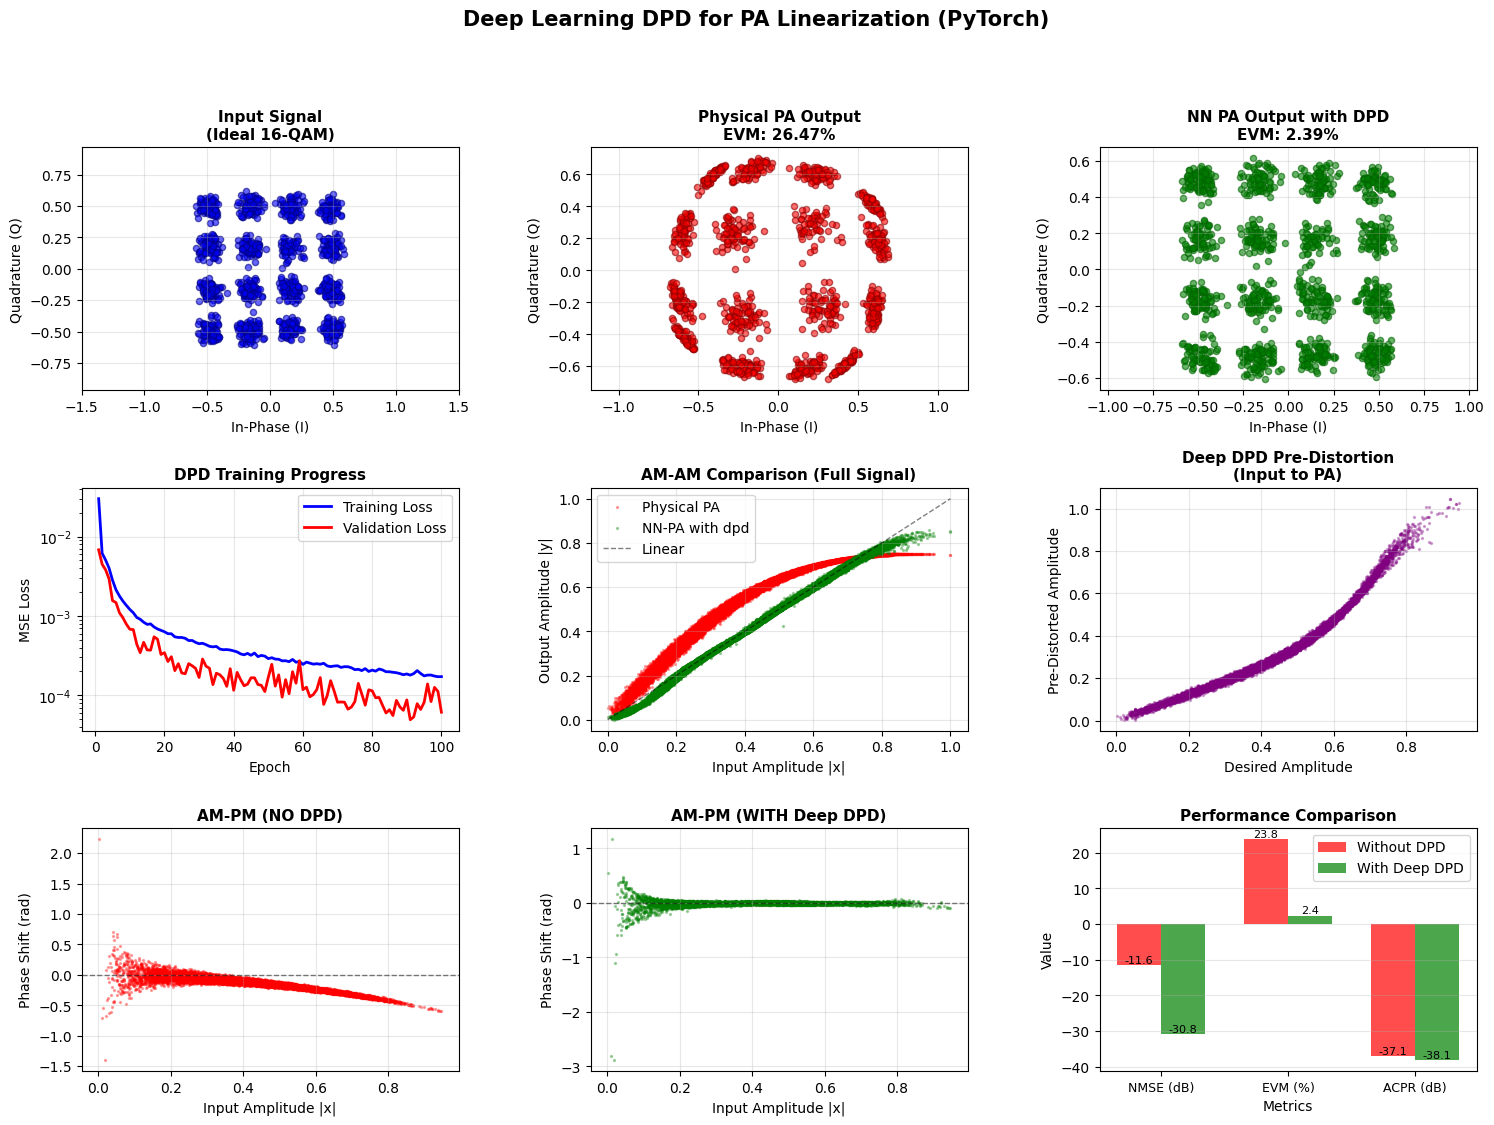


Simulation Complete!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import upfirdn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Global constants for model configuration
HIDDEN_DIMS=[128,64,32]
DROPOUT = 0.2

# ==========================================
# 1. 16-QAM Signal Generator
# ==========================================
def generate_realistic_16qam(num_symbols, sps, rolloff):
    """Generates a clean 16-QAM signal with RRC pulse shaping."""
    # 1. Create 16-QAM Constellation Map (4x4 grid)
    qam_map = np.array([x + 1j*y for x in range(-3, 4, 2) for y in range(-3, 4, 2)])
    qam_map /= np.sqrt(np.mean(np.abs(qam_map)**2))  # Normalize power

    # 2. Random Symbols
    symbols_idx = np.random.randint(0, 16, num_symbols)
    symbols = qam_map[symbols_idx]

    # 3. RRC Pulse Shaping
    span = 10
    num_taps = span * sps + 1
    t = np.arange(num_taps) - (num_taps - 1) // 2

    # RRC filter design
    h_rrc = np.zeros(num_taps)
    for i in range(num_taps):
        t_val = t[i] / float(sps)

        if t_val == 0.0:
            h_rrc[i] = 1.0 - rolloff + (4.0 * rolloff / np.pi)
        elif rolloff != 0 and abs(t_val) == 1.0 / (4.0 * rolloff):
            h_rrc[i] = (rolloff / np.sqrt(2.0)) * (
                (1.0 + 2.0 / np.pi) * np.sin(np.pi / (4.0 * rolloff)) +
                (1.0 - 2.0 / np.pi) * np.cos(np.pi / (4.0 * rolloff))
            )
        else:
            numerator = np.sin(np.pi * t_val * (1.0 - rolloff)) + \
                        4.0 * rolloff * t_val * np.cos(np.pi * t_val * (1.0 + rolloff))
            denominator = np.pi * t_val * (1.0 - (4.0 * rolloff * t_val) ** 2)
            h_rrc[i] = numerator / denominator

    h_rrc = h_rrc / np.sqrt(np.sum(h_rrc ** 2))

    # Upsample and filter
    upsampled = np.zeros(len(symbols) * sps, dtype=complex)
    upsampled[::sps] = symbols
    signal = np.convolve(upsampled, h_rrc, mode='same')

    # Remove edge effects
    trim = span * sps
    if len(signal) > 2 * trim:
        signal = signal[trim:-trim]

    # Peak normalization
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal / max_val

    return signal, symbols


# ==========================================
# 2.1 Physical PA Model
# ==========================================
class NoiselessPA:
    def __init__(self, memory_strength, saturation_level):
        self.mem_str = memory_strength
        self.sat_level = saturation_level

    def transmit(self, x):
        # Memory Effect
        x_delayed = np.roll(x, 1) * 0.5 + np.roll(x, 2) * 0.2
        x_eff = x + self.mem_str * x_delayed

        r = np.abs(x_eff)
        phi = np.angle(x_eff)

        # AM-AM (Saturation)
        gain_compression = self.sat_level * r / (1 + r**2)

        # AM-PM (Phase Twist)
        phase_distortion = -np.pi/6 * r**2

        return gain_compression * np.exp(1j * (phi + phase_distortion))

# ==========================================
# 2.2. Deep Learning PA Model (PyTorch)
# ==========================================


# =========================
# Neural Network PA Model
# =========================
class NNPA(nn.Module):
    """
    Neural network model to mimic a PA (AM-AM + AM-PM + memory)
    Input: Feature vector of past input samples (memory taps)
    Output: Complex PA output (I and Q)
    """

    def __init__(self, memory_depth=5, hidden_dims=HIDDEN_DIMS, dropout=DROPOUT):
        super(NNPA, self).__init__()
        self.memory_depth = memory_depth
        self.hidden_dims = hidden_dims
        self.dropout = dropout
        input_dim = 2 * (memory_depth + 1)  # real + imag for each tap



        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(dropout))
            prev_dim = h

        self.hidden = nn.Sequential(*layers)
        self.out_real = nn.Linear(prev_dim, 1)
        self.out_imag = nn.Linear(prev_dim, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.hidden(x)
        real = self.out_real(x)
        imag = self.out_imag(x)
        return torch.cat([real, imag], dim=1)

    def create_features(self, x):
        """Create memory polynomial features for NN-PA"""
        x = np.array(x)
        N = len(x)
        feats = []
        x_pad = np.pad(x, (self.memory_depth, 0), mode='constant')
        for i in range(N):
            window = x_pad[i:i+self.memory_depth+1][::-1]
            feats.append(np.concatenate([window.real, window.imag]))
        return np.array(feats)

# =========================
# Training function for NN-PA
# =========================
def train_nn_pa(pa_model, tx_signal, epochs, batch_size, lr, device='cpu'):
    """
    Train NN-PA using input-output data from physical PA.
    """
    scaler = StandardScaler()
    pa_model.device = device # Attach device to the model instance for later use

    # Create features for training
    X = pa_model.create_features(tx_signal)

    # Target: Output of real PA (NoiselessPA)
    pa = NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVEL)
    y_complex = pa.transmit(tx_signal)
    y = np.column_stack([y_complex.real, y_complex.imag])

    # Scale features
    X_scaled = scaler.fit_transform(X)
    pa_model.scaler = scaler # Attach scaler to the model instance

    # Split into train/validation (using 70/30 split)

    split_idx = int(len(X_scaled) * (1 -VALIDATION_SPLIT))
    X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Convert to PyTorch tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)

    # Create data loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(pa_model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    train_losses = []
    val_losses = []

    print(f"\nTraining NN-PA on {len(X_train)} samples...")
    for epoch in range(epochs):
        pa_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out = pa_model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        pa_model.eval()
        with torch.no_grad():
            val_outputs = pa_model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t).item()
            val_losses.append(val_loss)

        scheduler.step(val_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print("NN-PA training complete.")
    return pa_model


# =========================
# Applying trained NN-PA
# =========================
def apply_nn_pa(pa_model, tx_signal):
    # 1. Feature creation (same as training)
    X = pa_model.create_features(tx_signal)

    # 2. Scale using stored scaler
    X_scaled = pa_model.scaler.transform(X)

    # 3. Torch tensor
    X_t = torch.FloatTensor(X_scaled).to(pa_model.device)

    # 4. Inference
    pa_model.eval()
    with torch.no_grad():
        out = pa_model(X_t).cpu().numpy()

    # 5. Back to complex
    return out[:, 0] + 1j * out[:, 1]

# ==========================================
# 3. Deep Learning DPD Model (PyTorch)
# ==========================================
# class DeepDPD(nn.Module):
#     """
#     Deep Neural Network for Digital Pre-Distortion
#     Architecture: Input → BatchNorm → Dense Layers with Residual Connections → Output
#     """
#     def __init__(self, input_dim, hidden_dims,dropout=0.2):
#         super(DeepDPD, self).__init__()

#         self.input_bn = nn.BatchNorm1d(input_dim)

#         layers = []
#         prev_dim = input_dim

#         for i, hidden_dim in enumerate(hidden_dims):
#             # Dense block with residual connection
#             layers.append(nn.Linear(prev_dim, hidden_dim))
#             layers.append(nn.BatchNorm1d(hidden_dim))
#             layers.append(nn.LeakyReLU(0.2))
#             layers.append(nn.Dropout(dropout))
#             prev_dim = hidden_dim

#         self.hidden_layers = nn.Sequential(*layers)

#         # Separate heads for I and Q
#         self.output_real = nn.Linear(prev_dim, 1)
#         self.output_imag = nn.Linear(prev_dim, 1)

#         # Initialize weights
#         self._initialize_weights()

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)

#     def forward(self, x):
#         x = self.input_bn(x)
#         x = self.hidden_layers(x)
#         real = self.output_real(x)
#         imag = self.output_imag(x)
#         return torch.cat([real, imag], dim=1)

def create_lstm_features(x, memory_depth):
    x = np.asarray(x)
    N = len(x)
    x_pad = np.pad(x, (memory_depth, 0), mode='constant')

    feats = np.zeros((N, memory_depth + 1, 2))
    for i in range(N):
        window = x_pad[i:i+memory_depth+1][::-1]
        feats[i, :, 0] = window.real
        feats[i, :, 1] = window.imag

    return feats

class GRUDPD(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()

        self.gru = nn.GRU(
            input_size=input_size,     # I, Q
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size, 2)  # Output I, Q

    def forward(self, x):
        # x shape: (batch, seq_len, 2)
        out, _ = self.gru(x)
        out = out[:, -1, :]   # last time step
        out = self.fc(out)
        return out

# ==========================================
# 4. DPD Trainer Class
# ==========================================
# class DPDTrainer:
#     def __init__(self, memory_depth=5,  hidden_dims=HIDDEN_DIMS, dropout=DROPOUT, device='cpu'):
#         self.memory_depth = memory_depth
#         self.device = device
#         self.scaler = StandardScaler()
#         self.hidden_dims = hidden_dims
#         self.dropout = dropout
#         # Calculate input dimension
#         input_dim = (memory_depth + 1) * 2  # Real and Imag for each memory tap

#         self.model = DeepDPD(input_dim, hidden_dims, dropout).to(device)
#         self.criterion = nn.MSELoss()
#         self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
#         self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#             self.optimizer, mode='min', factor=0.5, patience=10
#         )

#     def _create_features(self, x):
#         """Create memory polynomial features"""
#         N = len(x)
#         feats = []
#         x_pad = np.pad(x, (self.memory_depth, 0), mode='constant')
#         for i in range(N):
#             window = x_pad[i : i + self.memory_depth + 1][::-1]
#             feats.append(np.concatenate([window.real, window.imag]))
#         return np.array(feats)

#     def train(self, pa_output, pa_input, epochs, batch_size, validation_split=0.2):
#         """
#         Train DPD using indirect learning architecture
#         pa_output: Signal after PA (distorted)
#         pa_input: Signal before PA (clean) - this is what we want to learn
#         """
#         # Create features
#         X = self._create_features(pa_output)
#         y = np.column_stack([pa_input.real, pa_input.imag])

#         # Scale features
#         X_scaled = self.scaler.fit_transform(X)

#         # Split into train/validation
#         split_idx = int(len(X_scaled) * (1 - validation_split))
#         X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
#         y_train, y_val = y[:split_idx], y[split_idx:]



#         # Convert to PyTorch tensors
#         X_train_t = torch.FloatTensor(X_train).to(self.device)
#         y_train_t = torch.FloatTensor(y_train).to(self.device)
#         X_val_t = torch.FloatTensor(X_val).to(self.device)
#         y_val_t = torch.FloatTensor(y_val).to(self.device)

#         # Create data loaders
#         train_dataset = TensorDataset(X_train_t, y_train_t)
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#         # Training loop
#         train_losses = []
#         val_losses = []

#         print(f"\nTraining Deep DPD Model...")
#         print(f"Architecture: Input({X.shape[1]}) \u2192 Hidden{[128,64,32]} \u2192 Output(2)")
#         print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

#         for epoch in range(epochs):
#             # Training
#             self.model.train()
#             epoch_loss = 0
#             for batch_X, batch_y in train_loader:
#                 self.optimizer.zero_grad()
#                 outputs = self.model(batch_X)
#                 loss = self.criterion(outputs, batch_y)
#                 loss.backward()
#                 self.optimizer.step()
#                 epoch_loss += loss.item()

#             avg_train_loss = epoch_loss / len(train_loader)
#             train_losses.append(avg_train_loss)

#             # Validation
#             self.model.eval()
#             with torch.no_grad():
#                 val_outputs = self.model(X_val_t)
#                 val_loss = self.criterion(val_outputs, y_val_t).item()
#                 val_losses.append(val_loss)

#             # Learning rate scheduling
#             self.scheduler.step(val_loss)

#             # Print progress
#             if (epoch + 1) % 20 == 0:
#                 print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

#         # Final validation score
#         self.model.eval()
#         with torch.no_grad():
#             val_pred = self.model(X_val_t).cpu().numpy()
#             val_pred_complex = val_pred[:, 0] + 1j * val_pred[:, 1]
#             val_true_complex = y_val[:, 0] + 1j * y_val[:, 1]

#             mse = np.mean(np.abs(val_pred_complex - val_true_complex)**2)
#             nmse = mse / np.mean(np.abs(val_true_complex)**2)
#             nmse_db = 10 * np.log10(nmse)

#             print(f"\nDPD Training Complete!")
#             print(f"Validation NMSE: {nmse_db:.2f} dB")

#         return train_losses, val_losses


#     def apply(self, x_desired):
#         X = self._create_features(x_desired)
#         X_scaled = self.scaler.transform(X)
#         X_tensor = torch.FloatTensor(X_scaled).to(self.device)

#         self.model.eval()
#         with torch.no_grad():
#             output = self.model(X_tensor).cpu().numpy()

#         return output[:, 0] + 1j * output[:, 1]
class GRUDPDTrainer:
    def __init__(self, memory_depth=5, device='cpu'):
        self.memory_depth = memory_depth
        self.device = device

        self.model = GRUDPD(
            input_size=2,
            hidden_size=64,
            num_layers=2,
            dropout=0.2
        ).to(device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def train(self, pa_output, pa_input, epochs=100, batch_size=128, validation_split=0.2):
      X = create_lstm_features(pa_output, self.memory_depth)
      y = np.column_stack([pa_input.real, pa_input.imag])

      # Split into train/validation
      split_idx = int(len(X) * (1 - validation_split))
      X_train, X_val = X[:split_idx], X[split_idx:]
      y_train, y_val = y[:split_idx], y[split_idx:]

      X_train_t = torch.FloatTensor(X_train).to(self.device)
      y_train_t = torch.FloatTensor(y_train).to(self.device)
      X_val_t = torch.FloatTensor(X_val).to(self.device)
      y_val_t = torch.FloatTensor(y_val).to(self.device)

      dataset = TensorDataset(X_train_t, y_train_t)
      loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

      train_losses = []
      val_losses = []

      for epoch in range(epochs):
          self.model.train()
          total_loss = 0
          for xb, yb in loader:
              self.optimizer.zero_grad()
              pred = self.model(xb)
              loss = self.criterion(pred, yb)
              loss.backward()
              self.optimizer.step()
              total_loss += loss.item()

          avg_loss = total_loss / len(loader)
          train_losses.append(avg_loss)

          # Validation
          self.model.eval()
          with torch.no_grad():
              val_pred = self.model(X_val_t)
              val_loss = self.criterion(val_pred, y_val_t).item()
              val_losses.append(val_loss)

          if (epoch + 1) % 20 == 0:
              print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_loss:.6f}, Val Loss: {val_loss:.6f}")

      return train_losses, val_losses

    def apply(self, x):
        X = create_lstm_features(x, self.memory_depth)
        X_t = torch.FloatTensor(X).to(self.device)

        self.model.eval()
        with torch.no_grad():
            out = self.model(X_t).cpu().numpy()

        return out[:, 0] + 1j * out[:, 1]


# ==========================================
# 5. Performance Metrics
# ==========================================
def calculate_metrics(tx_signal, rx_signal, sps=8):
    """Calculate EVM, NMSE, and ACPR"""
    # Align phases
    avg_rot = np.exp(-1j * np.angle(np.mean(rx_signal/tx_signal)))
    rx_aligned = rx_signal * avg_rot

    # NMSE (dB)
    nmse = np.mean(np.abs(rx_aligned - tx_signal)**2) / np.mean(np.abs(tx_signal)**2)
    nmse_db = 10 * np.log10(nmse)

    # EVM (%) - at symbol rate
    tx_symbols = tx_signal[::sps]
    rx_symbols = rx_aligned[::sps]
    evm_rms = np.sqrt(np.mean(np.abs(rx_symbols - tx_symbols)**2)) / np.sqrt(np.mean(np.abs(tx_symbols)**2))
    evm_percent = evm_rms * 100

    # ACPR
    fft_signal = np.fft.fftshift(np.fft.fft(rx_aligned))
    psd = np.abs(fft_signal)**2
    N = len(psd)

    main_start = int(N * 0.3)
    main_end = int(N * 0.7)
    main_power = np.sum(psd[main_start:main_end])

    adj_lower = np.sum(psd[int(N*0.1):int(N*0.3)])
    adj_upper = np.sum(psd[int(N*0.7):int(N*0.9)])
    adj_power = adj_lower + adj_upper

    acpr_db = 10 * np.log10(adj_power / main_power)

    return {
        'NMSE_dB': nmse_db,
        'EVM_%': evm_percent,
        'ACPR_dB': acpr_db
    }

# ==========================================
# 6. Run Simulation
# ==========================================

if __name__ == "__main__":

# Setup
    NUM_SYMBOLS = 4000
    SPS = 8
    ROLLOFF = 0.25
    MEMORY_STRENGTH = 0.18
    SATURATION_LEVEL = 1.5
    EPOCHS = 100
    BATCH_SIZE = 128
    LR=0.001
    # HIDDEN_DIMS=[128,64,32] # Moved to global scope
    VALIDATION_SPLIT = 0.3
    # DROPOUT = 0.2 # Moved to global scope


    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("="*70)
    print("Deep Learning DPD for PA Linearization")
    print("="*70)

    # Generate 16-QAM signal (reuse your function)
    tx_signal, tx_symbols = generate_realistic_16qam(NUM_SYMBOLS, sps=SPS, rolloff=ROLLOFF)

    # Initialize NN-PA and move to device

    nn_pa = NNPA(memory_depth=2, hidden_dims=HIDDEN_DIMS,dropout=DROPOUT).to(device)

    # Train NN-PA

    nn_pa = train_nn_pa(nn_pa, tx_signal, epochs=EPOCHS,batch_size=BATCH_SIZE,lr=LR, device=device)

    # Test NN-PA output
    rx_nn_pa = apply_nn_pa(nn_pa, tx_signal)

    # Compare NMSE vs physical PA
    pa = NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVEL)
    rx_real_pa = pa.transmit(tx_signal)
    nmse = np.mean(np.abs(rx_nn_pa - rx_real_pa)**2) / np.mean(np.abs(rx_real_pa)**2)
    nmse_db = 10*np.log10(nmse)
    print(f"NN-PA NMSE vs real PA: {nmse_db:.2f} dB")



    # Calculate metrics PHYSICAL PA
    metrics_PHYSICAL_PA = calculate_metrics(tx_signal, rx_real_pa, sps=SPS)
    print(f"\n--- Performance Physical PA ---") # Changed title
    print(f"NMSE: {metrics_PHYSICAL_PA['NMSE_dB']:.2f} dB")
    print(f"EVM: {metrics_PHYSICAL_PA['EVM_%']:.2f} %")
    print(f"ACPR: {metrics_PHYSICAL_PA['ACPR_dB']:.2f} dB")

    # Calculate metric_nn_PA
    metric_nn_PA = calculate_metrics(tx_signal, rx_nn_pa, sps=SPS)
    print(f"\n--- Performance NN-PA ---") # Changed title
    print(f"NMSE: {metric_nn_PA ['NMSE_dB']:.2f} dB")
    print(f"EVM: {metric_nn_PA['EVM_%']:.2f} %")
    print(f"ACPR: {metric_nn_PA['ACPR_dB']:.2f} dB")



    # Train Deep DPD
    split = int(0.7 * len(tx_signal))
    print(f"\n[3] Training Deep Learning DPD...")
    dpd = GRUDPDTrainer(memory_depth=5, device=device)

    split = int(0.7 * len(tx_signal))
    train_losses, val_losses = dpd.train(rx_nn_pa[:split], tx_signal[:split],validation_split=0.2,
                                          epochs=EPOCHS, batch_size=BATCH_SIZE)


    "P2 Epoch {ep+1}/{ph2_epochs} Loss {epoch_loss/len(train_loader.dataset):.6e}"



    # Apply DPD and test
    print("\n[4] Applying DPD and testing...")
    tx_predistorted = dpd.apply(tx_signal)

    rx_with_dpd =apply_nn_pa(nn_pa,tx_predistorted)

    # Calculate metrics WITH DPD
    metrics_with_dpd = calculate_metrics(tx_signal, rx_with_dpd, sps=SPS)
    print(f"\n--- Performance WITH Deep DPD ---")
    print(f"NMSE: {metrics_with_dpd['NMSE_dB']:.2f} dB")
    print(f"EVM: {metrics_with_dpd['EVM_%']:.2f} %")
    print(f"ACPR: {metrics_with_dpd['ACPR_dB']:.2f} dB")



    # Improvement
    print(f"\n--- IMPROVEMENT ---")
    print(f"NMSE Improvement: {metrics_PHYSICAL_PA['NMSE_dB'] - metrics_with_dpd['NMSE_dB']:.2f} dB")
    print(f"EVM Improvement: {metrics_PHYSICAL_PA['EVM_%'] - metrics_with_dpd['EVM_%']:.2f} %")
    print(f"ACPR Improvement: {metrics_PHYSICAL_PA['ACPR_dB'] - metrics_with_dpd['ACPR_dB']:.2f} dB")


    # ==========================================
    # 7. Visualization for NN-PA comparison
    # ==========================================
    fig = plt.figure(figsize=(18, 12)) # Initialize figure
    plt.subplots_adjust(wspace=0.35, hspace=0.4)

    # Align phases for plotting
    avg_rot_real_pa = np.exp(-1j * np.angle(np.mean(rx_real_pa/tx_signal)))
    avg_rot_nn_pa = np.exp(-1j * np.angle(np.mean(rx_nn_pa/tx_signal)))



    # Sample at symbol rate for constellations (using the test part of the signal)

    # Split into train/validation (using 70/30 split)


    split = int(0.7 * len(tx_signal))

    tx_sampled = tx_signal[split:][::SPS]
    rx_real_pa_sampled = (rx_real_pa[split:] * avg_rot_real_pa)[::SPS]
    rx_nn_pa_sampled = (rx_nn_pa[split:] * avg_rot_nn_pa)[::SPS]
    # Align DPD output to original TX for plotting
    avg_rot_dpd = np.exp(-1j * np.angle(np.mean(rx_with_dpd / tx_signal)))
    rx_with_dpd_sampled = (rx_with_dpd[split:] * avg_rot_dpd)[::SPS]


    # Row 1: Constellations
    ax1 = plt.subplot(3, 3, 1) # Renamed from ax2 for clarity, since it's the first plot
    ax1.scatter(tx_sampled.real, tx_sampled.imag, c='blue', s=20, alpha=0.6, edgecolors='navy')
    ax1.set_title("Input Signal\n(Ideal 16-QAM)", fontsize=11, fontweight='bold')
    ax1.set_xlabel("In-Phase (I)")
    ax1.set_ylabel("Quadrature (Q)")
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)


    ax2 = plt.subplot(3, 3, 2)
    ax2.scatter(rx_real_pa_sampled.real, rx_real_pa_sampled.imag, c='red', s=20, alpha=0.6, edgecolors='darkred')
    ax2.set_title(f"Physical PA Output\nEVM: {metrics_PHYSICAL_PA['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax2.set_xlabel("In-Phase (I)")
    ax2.set_ylabel("Quadrature (Q)")
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')

    ax3 = plt.subplot(3, 3, 3)
    ax3.scatter(rx_with_dpd_sampled.real, rx_with_dpd_sampled.imag, c='green', s=20, alpha=0.6, edgecolors='darkgreen')
    ax3.set_title(f"NN PA Output with DPD\nEVM: {metrics_with_dpd['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax3.set_xlabel("In-Phase (I)")
    ax3.set_ylabel("Quadrature (Q)")
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')

    # Row 2: Training curves and AM-AM
    ax4 = plt.subplot(3, 3, 4)
    epochs_range = range(1, len(train_losses) + 1)
    ax4.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax4.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('MSE Loss')
    ax4.set_title('DPD Training Progress', fontsize=11, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # Row 2: AM-AM Comparison (full signal, not just split)
    ax5 = plt.subplot(3, 3, 5)
    ax5.scatter(np.abs(tx_signal), np.abs(rx_real_pa), c='red', s=2, alpha=0.3, label='Physical PA')
    ax5.scatter(np.abs(tx_signal), np.abs(rx_with_dpd), c='green', s=2, alpha=0.3, label='NN-PA with dpd')
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Linear')
    ax5.set_title("AM-AM Comparison (Full Signal)", fontsize=11, fontweight='bold')
    ax5.set_xlabel("Input Amplitude |x|")
    ax5.set_ylabel("Output Amplitude |y|")
    ax5.legend()
    ax5.grid(True, alpha=0.3)


    ax6 = plt.subplot(3, 3, 6)
    ax6.scatter(np.abs(tx_signal[split:]), np.abs(tx_predistorted[split:]), c='purple', s=2, alpha=0.3)
    ax6.set_title("Deep DPD Pre-Distortion\n(Input to PA)", fontsize=11, fontweight='bold')
    ax6.set_xlabel("Desired Amplitude")
    ax6.set_ylabel("Pre-Distorted Amplitude")
    ax6.grid(True, alpha=0.3)


    # Row 3: AM-PM and Performance
    ax7 = plt.subplot(3, 3, 7)
    phase_diff_no_dpd = np.angle(rx_real_pa[split:]) - np.angle(tx_signal[split:])
    phase_diff_no_dpd = (phase_diff_no_dpd + np.pi) % (2 * np.pi) - np.pi
    ax7.scatter(np.abs(tx_signal[split:]), phase_diff_no_dpd, c='red', s=2, alpha=0.3, label='No DPD')
    ax7.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
    ax7.set_title("AM-PM (NO DPD)", fontsize=11, fontweight='bold')
    ax7.set_xlabel("Input Amplitude |x|")
    ax7.set_ylabel("Phase Shift (rad)")
    ax7.grid(True, alpha=0.3)


    ax8 = plt.subplot(3, 3, 8)
    phase_diff_with_dpd = np.angle(rx_with_dpd[split:]) - np.angle(tx_signal[split:])
    phase_diff_with_dpd = (phase_diff_with_dpd + np.pi) % (2 * np.pi) - np.pi
    ax8.scatter(np.abs(tx_signal[split:]), phase_diff_with_dpd, c='green', s=2, alpha=0.3, label='With DPD')
    ax8.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
    ax8.set_title("AM-PM (WITH Deep DPD)", fontsize=11, fontweight='bold')
    ax8.set_xlabel("Input Amplitude |x|")
    ax8.set_ylabel("Phase Shift (rad)")
    ax8.grid(True, alpha=0.3)


    # Performance Comparison
    ax9 = plt.subplot(3, 3, 9)
    metrics_names = ['NMSE (dB)', 'EVM (%)', 'ACPR (dB)']
    no_dpd_vals = [metric_nn_PA['NMSE_dB'], metric_nn_PA['EVM_%'], metric_nn_PA['ACPR_dB']]
    with_dpd_vals = [metrics_with_dpd['NMSE_dB'], metrics_with_dpd['EVM_%'], metrics_with_dpd['ACPR_dB']]

    x_pos = np.arange(len(metrics_names))
    width = 0.35

    bars1 = ax9.bar(x_pos - width/2, no_dpd_vals, width, label='Without DPD', color='red', alpha=0.7)
    bars2 = ax9.bar(x_pos + width/2, with_dpd_vals, width, label='With Deep DPD', color='green', alpha=0.7)

    ax9.set_xlabel('Metrics')
    ax9.set_ylabel('Value')
    ax9.set_title('Performance Comparison', fontsize=11, fontweight='bold')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels(metrics_names, fontsize=9)
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=8)

    plt.suptitle("Deep Learning DPD for PA Linearization (PyTorch)",
                 fontsize=15, fontweight='bold', y=0.995)
    plt.show()

    print("\n" + "="*70)
    print("Simulation Complete!")
    print("="*70)


    #TEST DATA
    # tx_test, _ = generate_realistic_16qam(4000, sps=SPS, rolloff=ROLLOFF)


    # # Initialize NN-PA and move to device
    # nn_pa = NNPA(memory_depth=2, hidden_dims=HIDDEN_DIMS).to(device)

    # # Train NN-PA
    # nn_pa = train_nn_pa(nn_pa, tx_test, epochs=EPOCHS, device=device)

    # rx_nn_test = apply_nn_pa(nn_pa, tx_test)
    # pa= NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVRL)
    # rx_real_test = pa.transmit(tx_test)

    # nmse_test = np.mean(np.abs(rx_nn_test - rx_real_test)**2) / np.mean(np.abs(rx_real_test)**2)
    # print(10*np.log10(nmse_test))

# LSTM DPD

Using device: cuda
Deep Learning DPD for PA Linearization

Training NN-PA on 22288 samples...
Epoch [20/100], Train Loss: 0.005277, Val Loss: 0.000588
Epoch [40/100], Train Loss: 0.004531, Val Loss: 0.000599
Epoch [60/100], Train Loss: 0.004310, Val Loss: 0.000471
Epoch [80/100], Train Loss: 0.004108, Val Loss: 0.000240
Epoch [100/100], Train Loss: 0.004091, Val Loss: 0.000261
NN-PA training complete.
NN-PA NMSE vs real PA: -28.12 dB

--- Performance Physical PA ---
NMSE: -10.58 dB
EVM: 26.47 %
ACPR: -43.01 dB

--- Performance NN-PA ---
NMSE: -11.57 dB
EVM: 23.81 %
ACPR: -37.11 dB

[3] Training Deep Learning DPD...

Training Deep DPD Model...
Training samples: 15601, Validation samples: 6687
Epoch [20/100] Train Loss: 0.001008, Val Loss: 0.000440
Epoch [40/100] Train Loss: 0.000439, Val Loss: 0.000265
Epoch [60/100] Train Loss: 0.000304, Val Loss: 0.000171
Epoch [80/100] Train Loss: 0.000238, Val Loss: 0.000098
Epoch [100/100] Train Loss: 0.000200, Val Loss: 0.000086
DPD training compl


--- Performance WITH Deep DPD ---
NMSE: -29.17 dB
EVM: 2.89 %
ACPR: -37.67 dB

--- IMPROVEMENT ---
NMSE Improvement: 18.59 dB
EVM Improvement: 23.58 %
ACPR Improvement: -5.34 dB


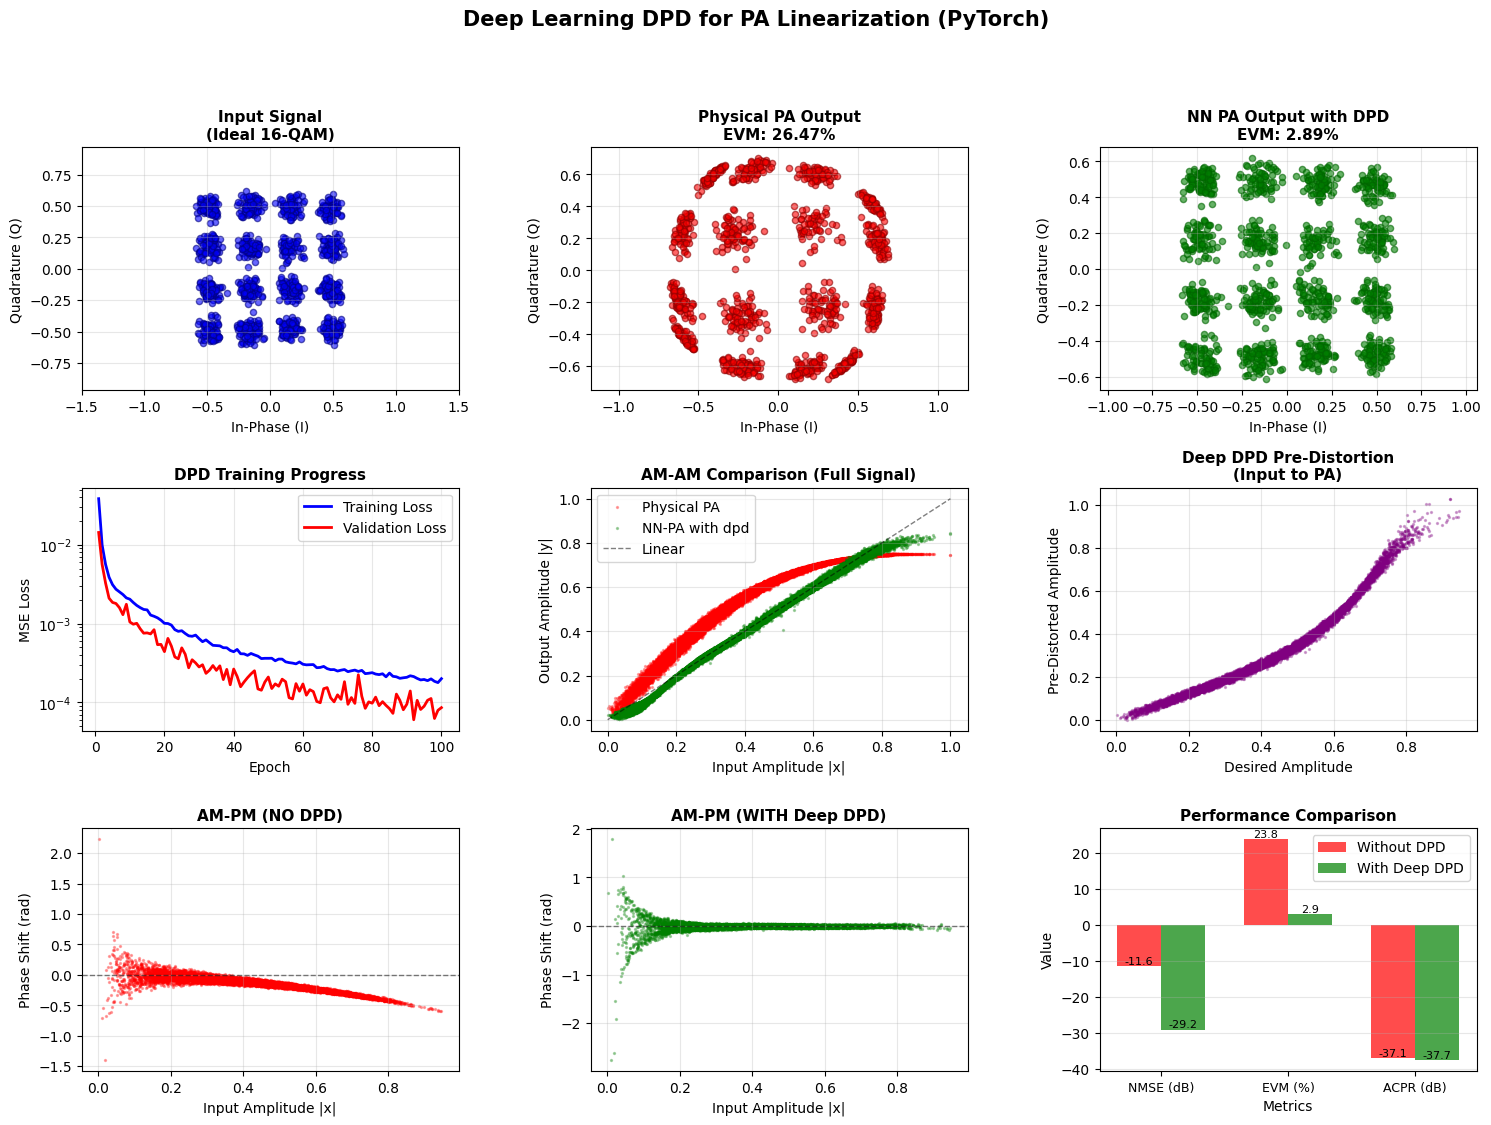


Simulation Complete!


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import upfirdn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Global constants for model configuration
HIDDEN_DIMS=[128,64,32]
DROPOUT = 0.2

# ==========================================
# 1. 16-QAM Signal Generator
# ==========================================
def generate_realistic_16qam(num_symbols, sps, rolloff):
    """Generates a clean 16-QAM signal with RRC pulse shaping."""
    # 1. Create 16-QAM Constellation Map (4x4 grid)
    qam_map = np.array([x + 1j*y for x in range(-3, 4, 2) for y in range(-3, 4, 2)])
    qam_map /= np.sqrt(np.mean(np.abs(qam_map)**2))  # Normalize power

    # 2. Random Symbols
    symbols_idx = np.random.randint(0, 16, num_symbols)
    symbols = qam_map[symbols_idx]

    # 3. RRC Pulse Shaping
    span = 10
    num_taps = span * sps + 1
    t = np.arange(num_taps) - (num_taps - 1) // 2

    # RRC filter design
    h_rrc = np.zeros(num_taps)
    for i in range(num_taps):
        t_val = t[i] / float(sps)

        if t_val == 0.0:
            h_rrc[i] = 1.0 - rolloff + (4.0 * rolloff / np.pi)
        elif rolloff != 0 and abs(t_val) == 1.0 / (4.0 * rolloff):
            h_rrc[i] = (rolloff / np.sqrt(2.0)) * (
                (1.0 + 2.0 / np.pi) * np.sin(np.pi / (4.0 * rolloff)) +
                (1.0 - 2.0 / np.pi) * np.cos(np.pi / (4.0 * rolloff))
            )
        else:
            numerator = np.sin(np.pi * t_val * (1.0 - rolloff)) + \
                        4.0 * rolloff * t_val * np.cos(np.pi * t_val * (1.0 + rolloff))
            denominator = np.pi * t_val * (1.0 - (4.0 * rolloff * t_val) ** 2)
            h_rrc[i] = numerator / denominator

    h_rrc = h_rrc / np.sqrt(np.sum(h_rrc ** 2))

    # Upsample and filter
    upsampled = np.zeros(len(symbols) * sps, dtype=complex)
    upsampled[::sps] = symbols
    signal = np.convolve(upsampled, h_rrc, mode='same')

    # Remove edge effects
    trim = span * sps
    if len(signal) > 2 * trim:
        signal = signal[trim:-trim]

    # Peak normalization
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        signal = signal / max_val

    return signal, symbols


# ==========================================
# 2.1 Physical PA Model
# ==========================================
class NoiselessPA:
    def __init__(self, memory_strength, saturation_level):
        self.mem_str = memory_strength
        self.sat_level = saturation_level

    def transmit(self, x):
        # Memory Effect
        x_delayed = np.roll(x, 1) * 0.5 + np.roll(x, 2) * 0.2
        x_eff = x + self.mem_str * x_delayed

        r = np.abs(x_eff)
        phi = np.angle(x_eff)

        # AM-AM (Saturation)
        gain_compression = self.sat_level * r / (1 + r**2)

        # AM-PM (Phase Twist)
        phase_distortion = -np.pi/6 * r**2

        return gain_compression * np.exp(1j * (phi + phase_distortion))

# ==========================================
# 2.2. Deep Learning PA Model (PyTorch)
# ==========================================


# =========================
# Neural Network PA Model
# =========================
class NNPA(nn.Module):
    """
    Neural network model to mimic a PA (AM-AM + AM-PM + memory)
    Input: Feature vector of past input samples (memory taps)
    Output: Complex PA output (I and Q)
    """

    def __init__(self, memory_depth=5, hidden_dims=HIDDEN_DIMS, dropout=DROPOUT):
        super(NNPA, self).__init__()
        self.memory_depth = memory_depth
        self.hidden_dims = hidden_dims
        self.dropout = dropout
        input_dim = 2 * (memory_depth + 1)  # real + imag for each tap



        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(dropout))
            prev_dim = h

        self.hidden = nn.Sequential(*layers)
        self.out_real = nn.Linear(prev_dim, 1)
        self.out_imag = nn.Linear(prev_dim, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.hidden(x)
        real = self.out_real(x)
        imag = self.out_imag(x)
        return torch.cat([real, imag], dim=1)

    def create_features(self, x):
        """Create memory polynomial features for NN-PA"""
        x = np.array(x)
        N = len(x)
        feats = []
        x_pad = np.pad(x, (self.memory_depth, 0), mode='constant')
        for i in range(N):
            window = x_pad[i:i+self.memory_depth+1][::-1]
            feats.append(np.concatenate([window.real, window.imag]))
        return np.array(feats)

# =========================
# Training function for NN-PA
# =========================
def train_nn_pa(pa_model, tx_signal, epochs, batch_size, lr, device='cpu'):
    """
    Train NN-PA using input-output data from physical PA.
    """
    scaler = StandardScaler()
    pa_model.device = device # Attach device to the model instance for later use

    # Create features for training
    X = pa_model.create_features(tx_signal)

    # Target: Output of real PA (NoiselessPA)
    pa = NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVEL)
    y_complex = pa.transmit(tx_signal)
    y = np.column_stack([y_complex.real, y_complex.imag])

    # Scale features
    X_scaled = scaler.fit_transform(X)
    pa_model.scaler = scaler # Attach scaler to the model instance

    # Split into train/validation (using 70/30 split)

    split_idx = int(len(X_scaled) * (1 -VALIDATION_SPLIT))
    X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Convert to PyTorch tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)

    # Create data loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(pa_model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    train_losses = []
    val_losses = []

    print(f"\nTraining NN-PA on {len(X_train)} samples...")
    for epoch in range(epochs):
        pa_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out = pa_model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        pa_model.eval()
        with torch.no_grad():
            val_outputs = pa_model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t).item()
            val_losses.append(val_loss)

        scheduler.step(val_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print("NN-PA training complete.")
    return pa_model, train_losses, val_losses


# =========================
# Applying trained NN-PA
# =========================
def apply_nn_pa(pa_model, tx_signal):
    # 1. Feature creation (same as training)
    X = pa_model.create_features(tx_signal)

    # 2. Scale using stored scaler
    X_scaled = pa_model.scaler.transform(X)

    # 3. Torch tensor
    X_t = torch.FloatTensor(X_scaled).to(pa_model.device)

    # 4. Inference
    pa_model.eval()
    with torch.no_grad():
        out = pa_model(X_t).cpu().numpy()

    # 5. Back to complex
    return out[:, 0] + 1j * out[:, 1]

# ==========================================
# 3. Deep Learning DPD Model (PyTorch)
# ==========================================
# class DeepDPD(nn.Module):
#     """
#     Deep Neural Network for Digital Pre-Distortion
#     Architecture: Input → BatchNorm → Dense Layers with Residual Connections → Output
#     """
#     def __init__(self, input_dim, hidden_dims,dropout=0.2):
#         super(DeepDPD, self).__init__()

#         self.input_bn = nn.BatchNorm1d(input_dim)

#         layers = []
#         prev_dim = input_dim

#         for i, hidden_dim in enumerate(hidden_dims):
#             # Dense block with residual connection
#             layers.append(nn.Linear(prev_dim, hidden_dim))
#             layers.append(nn.BatchNorm1d(hidden_dim))
#             layers.append(nn.LeakyReLU(0.2))
#             layers.append(nn.Dropout(dropout))
#             prev_dim = hidden_dim

#         self.hidden_layers = nn.Sequential(*layers)

#         # Separate heads for I and Q
#         self.output_real = nn.Linear(prev_dim, 1)
#         self.output_imag = nn.Linear(prev_dim, 1)

#         # Initialize weights
#         self._initialize_weights()

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)

#     def forward(self, x):
#         x = self.input_bn(x)
#         x = self.hidden_layers(x)
#         real = self.output_real(x)
#         imag = self.output_imag(x)
#         return torch.cat([real, imag], dim=1)

class LSTMDPD(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,     # I, Q
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size, 2)  # Output I, Q

    def forward(self, x):
        # x shape: (batch, seq_len, 2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]          # last time step
        out = self.fc(out)
        return out


# ==========================================
# 4. DPD Trainer Class
# ==========================================
# class DPDTrainer:
    # def __init__(self, memory_depth=5,  hidden_dims=HIDDEN_DIMS, dropout=DROPOUT, device='cpu'):
    #     self.memory_depth = memory_depth
    #     self.device = device
    #     self.scaler = StandardScaler()
    #     self.hidden_dims = hidden_dims
    #     self.dropout = dropout
    #     # Calculate input dimension
    #     input_dim = (memory_depth + 1) * 2  # Real and Imag for each memory tap

    #     self.model = DeepDPD(input_dim, hidden_dims, dropout).to(device)
    #     self.criterion = nn.MSELoss()
    #     self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
    #     self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    #         self.optimizer, mode='min', factor=0.5, patience=10
    #     )

    # def _create_features(self, x):
    #     """Create memory polynomial features"""
    #     N = len(x)
    #     feats = []
    #     x_pad = np.pad(x, (self.memory_depth, 0), mode='constant')
    #     for i in range(N):
    #         window = x_pad[i : i + self.memory_depth + 1][::-1]
    #         feats.append(np.concatenate([window.real, window.imag]))
    #     return np.array(feats)
def create_lstm_features(x, memory_depth):
    """
    Output shape: (N, memory_depth+1, 2)
    """
    x = np.asarray(x)
    N = len(x)
    x_pad = np.pad(x, (memory_depth, 0), mode='constant')

    feats = np.zeros((N, memory_depth + 1, 2))
    for i in range(N):
        window = x_pad[i:i+memory_depth+1][::-1]
        feats[i, :, 0] = window.real
        feats[i, :, 1] = window.imag

    return feats


class LSTMDPDTrainer:
    def __init__(self, memory_depth=5, device='cpu'):
        self.memory_depth = memory_depth
        self.device = device

        self.model = LSTMDPD(
            input_size=2,
            hidden_size=64,
            num_layers=2,
            dropout=0.2
        ).to(device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def train(self, pa_output, pa_input, epochs=100, batch_size=128, validation_split=0.2):
        X = create_lstm_features(pa_output, self.memory_depth)
        y = np.column_stack([pa_input.real, pa_input.imag])

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)

        X_train_t = torch.FloatTensor(X_train).to(self.device)
        y_train_t = torch.FloatTensor(y_train).to(self.device)
        X_val_t = torch.FloatTensor(X_val).to(self.device)
        y_val_t = torch.FloatTensor(y_val).to(self.device)

        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        train_losses = []
        val_losses = []

        print(f"\nTraining Deep DPD Model...")
        print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0

            for xb, yb in train_loader:
                self.optimizer.zero_grad()
                pred = self.model(xb)
                loss = self.criterion(pred, yb)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_train_loss = total_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = self.criterion(val_pred, y_val_t).item()
                val_losses.append(val_loss)

            if (epoch + 1) % 20 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

        print("DPD training complete.")
        return train_losses, val_losses

    def apply(self, x):
        X = create_lstm_features(x, self.memory_depth)
        X_t = torch.FloatTensor(X).to(self.device)

        self.model.eval()
        with torch.no_grad():
            out = self.model(X_t).cpu().numpy()

        return out[:, 0] + 1j * out[:, 1]



    # def train(self, pa_output, pa_input, epochs, batch_size, validation_split=0.2):
    #     """
    #     Train DPD using indirect learning architecture
    #     pa_output: Signal after PA (distorted)
    #     pa_input: Signal before PA (clean) - this is what we want to learn
    #     """
    #     # Create features
    #     X = self._create_features(pa_output)
    #     y = np.column_stack([pa_input.real, pa_input.imag])

    #     # Scale features
    #     X_scaled = self.scaler.fit_transform(X)

    #     # Split into train/validation
    #     split_idx = int(len(X_scaled) * (1 - validation_split))
    #     X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
    #     y_train, y_val = y[:split_idx], y[split_idx:]



    #     # Convert to PyTorch tensors
    #     X_train_t = torch.FloatTensor(X_train).to(self.device)
    #     y_train_t = torch.FloatTensor(y_train).to(self.device)
    #     X_val_t = torch.FloatTensor(X_val).to(self.device)
    #     y_val_t = torch.FloatTensor(y_val).to(self.device)

    #     # Create data loaders
    #     train_dataset = TensorDataset(X_train_t, y_train_t)
    #     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    #     # Training loop
    #     train_losses = []
    #     val_losses = []

    #     print(f"\nTraining Deep DPD Model...")
    #     print(f"Architecture: Input({X.shape[1]}) \u2192 Hidden{[128,64,32]} \u2192 Output(2)")
    #     print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

    #     for epoch in range(epochs):
    #         # Training
    #         self.model.train()
    #         epoch_loss = 0
    #         for batch_X, batch_y in train_loader:
    #             self.optimizer.zero_grad()
    #             outputs = self.model(batch_X)
    #             loss = self.criterion(outputs, batch_y)
    #             loss.backward()
    #             self.optimizer.step()
    #             epoch_loss += loss.item()

    #         avg_train_loss = epoch_loss / len(train_loader)
    #         train_losses.append(avg_train_loss)

    #         # Validation
    #         self.model.eval()
    #         with torch.no_grad():
    #             val_outputs = self.model(X_val_t)
    #             val_loss = self.criterion(val_outputs, y_val_t).item()
    #             val_losses.append(val_loss)

    #         # Learning rate scheduling
    #         self.scheduler.step(val_loss)

    #         # Print progress
    #         if (epoch + 1) % 20 == 0:
    #             print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

    #     # Final validation score
    #     self.model.eval()
    #     with torch.no_grad():
    #         val_pred = self.model(X_val_t).cpu().numpy()
    #         val_pred_complex = val_pred[:, 0] + 1j * val_pred[:, 1]
    #         val_true_complex = y_val[:, 0] + 1j * y_val[:, 1]

    #         mse = np.mean(np.abs(val_pred_complex - val_true_complex)**2)
    #         nmse = mse / np.mean(np.abs(val_true_complex)**2)
    #         nmse_db = 10 * np.log10(nmse)

    #         print(f"\nDPD Training Complete!")
    #         print(f"Validation NMSE: {nmse_db:.2f} dB")

    #     return train_losses, val_losses


    # def apply(self, x_desired):
    #     X = self._create_features(x_desired)
    #     X_scaled = self.scaler.transform(X)
    #     X_tensor = torch.FloatTensor(X_scaled).to(self.device)

    #     self.model.eval()
    #     with torch.no_grad():
    #         output = self.model(X_tensor).cpu().numpy()

    #     return output[:, 0] + 1j * output[:, 1]


# ==========================================
# 5. Performance Metrics
# ==========================================
def calculate_metrics(tx_signal, rx_signal, sps=8):
    """Calculate EVM, NMSE, and ACPR"""
    # Align phases
    avg_rot = np.exp(-1j * np.angle(np.mean(rx_signal/tx_signal)))
    rx_aligned = rx_signal * avg_rot

    # NMSE (dB)
    nmse = np.mean(np.abs(rx_aligned - tx_signal)**2) / np.mean(np.abs(tx_signal)**2)
    nmse_db = 10 * np.log10(nmse)

    # EVM (%) - at symbol rate
    tx_symbols = tx_signal[::sps]
    rx_symbols = rx_aligned[::sps]
    evm_rms = np.sqrt(np.mean(np.abs(rx_symbols - tx_symbols)**2)) / np.sqrt(np.mean(np.abs(tx_symbols)**2))
    evm_percent = evm_rms * 100

    # ACPR
    fft_signal = np.fft.fftshift(np.fft.fft(rx_aligned))
    psd = np.abs(fft_signal)**2
    N = len(psd)

    main_start = int(N * 0.3)
    main_end = int(N * 0.7)
    main_power = np.sum(psd[main_start:main_end])

    adj_lower = np.sum(psd[int(N*0.1):int(N*0.3)])
    adj_upper = np.sum(psd[int(N*0.7):int(N*0.9)])
    adj_power = adj_lower + adj_upper

    acpr_db = 10 * np.log10(adj_power / main_power)

    return {
        'NMSE_dB': nmse_db,
        'EVM_%': evm_percent,
        'ACPR_dB': acpr_db
    }

# ==========================================
# 6. Run Simulation
# ==========================================

if __name__ == "__main__":

# Setup
    NUM_SYMBOLS = 4000
    SPS = 8
    ROLLOFF = 0.25
    MEMORY_STRENGTH = 0.18
    SATURATION_LEVEL = 1.5
    EPOCHS = 100
    BATCH_SIZE = 128
    LR=0.001
    # HIDDEN_DIMS=[128,64,32] # Moved to global scope
    VALIDATION_SPLIT = 0.3
    # DROPOUT = 0.2 # Moved to global scope


    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("="*70)
    print("Deep Learning DPD for PA Linearization")
    print("="*70)

    # Generate 16-QAM signal (reuse your function)
    tx_signal, tx_symbols = generate_realistic_16qam(NUM_SYMBOLS, sps=SPS, rolloff=ROLLOFF)

    # Initialize NN-PA and move to device

    nn_pa = NNPA(memory_depth=2, hidden_dims=HIDDEN_DIMS,dropout=DROPOUT).to(device)

    # Train NN-PA

    nn_pa, nn_pa_train_losses, nn_pa_val_losses = train_nn_pa(nn_pa, tx_signal, epochs=EPOCHS,batch_size=BATCH_SIZE,lr=LR, device=device)

    # Test NN-PA output
    rx_nn_pa = apply_nn_pa(nn_pa, tx_signal)

    # Compare NMSE vs physical PA
    pa = NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVEL)
    rx_real_pa = pa.transmit(tx_signal)
    nmse = np.mean(np.abs(rx_nn_pa - rx_real_pa)**2) / np.mean(np.abs(rx_real_pa)**2)
    nmse_db = 10*np.log10(nmse)
    print(f"NN-PA NMSE vs real PA: {nmse_db:.2f} dB")



    # Calculate metrics PHYSICAL PA
    metrics_PHYSICAL_PA = calculate_metrics(tx_signal, rx_real_pa, sps=SPS)
    print(f"\n--- Performance Physical PA ---") # Changed title
    print(f"NMSE: {metrics_PHYSICAL_PA['NMSE_dB']:.2f} dB")
    print(f"EVM: {metrics_PHYSICAL_PA['EVM_%']:.2f} %")
    print(f"ACPR: {metrics_PHYSICAL_PA['ACPR_dB']:.2f} dB")

    # Calculate metric_nn_PA
    metric_nn_PA = calculate_metrics(tx_signal, rx_nn_pa, sps=SPS)
    print(f"\n--- Performance NN-PA ---") # Changed title
    print(f"NMSE: {metric_nn_PA ['NMSE_dB']:.2f} dB")
    print(f"EVM: {metric_nn_PA['EVM_%']:.2f} %")
    print(f"ACPR: {metric_nn_PA['ACPR_dB']:.2f} dB")



    # Train Deep DPD
    split = int(0.7 * len(tx_signal))
    print(f"\n[3] Training Deep Learning DPD...")
    # dpd = DPDTrainer(memory_depth=5, hidden_dims=HIDDEN_DIMS, dropout=0.2, device=device)
    # split = int(0.7 * len(tx_signal))
    # train_losses, val_losses = dpd.train(rx_nn_pa[:split], tx_signal[:split],validation_split=0.2,
    #                                       epochs=EPOCHS, batch_size=BATCH_SIZE)


    # "P2 Epoch {ep+1}/{ph2_epochs} Loss {epoch_loss/len(train_loader.dataset):.6e}"



    # # Apply DPD and test
    # print("\n[4] Applying DPD and testing...")
    # tx_predistorted = dpd.apply(tx_signal)

    # rx_with_dpd =apply_nn_pa(nn_pa,tx_predistorted)
    dpd = LSTMDPDTrainer(memory_depth=5, device=device)

    train_losses, val_losses = dpd.train(
        pa_output=rx_nn_pa[:split],
        pa_input=tx_signal[:split],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT
    )

    tx_predistorted = dpd.apply(tx_signal)
    rx_with_dpd = apply_nn_pa(nn_pa, tx_predistorted)


    # Calculate metrics WITH DPD
    metrics_with_dpd = calculate_metrics(tx_signal, rx_with_dpd, sps=SPS)
    print(f"\n--- Performance WITH Deep DPD ---")
    print(f"NMSE: {metrics_with_dpd['NMSE_dB']:.2f} dB")
    print(f"EVM: {metrics_with_dpd['EVM_%']:.2f} %")
    print(f"ACPR: {metrics_with_dpd['ACPR_dB']:.2f} dB")



    # Improvement
    print(f"\n--- IMPROVEMENT ---")
    print(f"NMSE Improvement: {metrics_PHYSICAL_PA['NMSE_dB'] - metrics_with_dpd['NMSE_dB']:.2f} dB")
    print(f"EVM Improvement: {metrics_PHYSICAL_PA['EVM_%'] - metrics_with_dpd['EVM_%']:.2f} %")
    print(f"ACPR Improvement: {metrics_PHYSICAL_PA['ACPR_dB'] - metrics_with_dpd['ACPR_dB']:.2f} dB")


    # ==========================================
    # 7. Visualization for NN-PA comparison
    # ==========================================
    fig = plt.figure(figsize=(18, 12)) # Initialize figure
    plt.subplots_adjust(wspace=0.35, hspace=0.4)

    # Align phases for plotting
    avg_rot_real_pa = np.exp(-1j * np.angle(np.mean(rx_real_pa/tx_signal)))
    avg_rot_nn_pa = np.exp(-1j * np.angle(np.mean(rx_nn_pa/tx_signal)))

    # Sample at symbol rate for constellations (using the test part of the signal)

    # Split into train/validation (using 70/30 split)


    split = int(0.7 * len(tx_signal))

    tx_sampled = tx_signal[split:][::SPS]
    rx_real_pa_sampled = (rx_real_pa[split:] * avg_rot_real_pa)[::SPS]
    rx_nn_pa_sampled = (rx_nn_pa[split:] * avg_rot_nn_pa)[::SPS]
     # Align DPD output to original TX for plotting
    avg_rot_dpd = np.exp(-1j * np.angle(np.mean(rx_with_dpd / tx_signal)))
    rx_with_dpd_sampled = (rx_with_dpd[split:] * avg_rot_dpd)[::SPS]


    # Row 1: Constellations
    ax1 = plt.subplot(3, 3, 1) # Renamed from ax2 for clarity, since it's the first plot
    ax1.scatter(tx_sampled.real, tx_sampled.imag, c='blue', s=20, alpha=0.6, edgecolors='navy')
    ax1.set_title("Input Signal\n(Ideal 16-QAM)", fontsize=11, fontweight='bold')
    ax1.set_xlabel("In-Phase (I)")
    ax1.set_ylabel("Quadrature (Q)")
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)


    ax2 = plt.subplot(3, 3, 2)
    ax2.scatter(rx_real_pa_sampled.real, rx_real_pa_sampled.imag, c='red', s=20, alpha=0.6, edgecolors='darkred')
    ax2.set_title(f"Physical PA Output\nEVM: {metrics_PHYSICAL_PA['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax2.set_xlabel("In-Phase (I)")
    ax2.set_ylabel("Quadrature (Q)")
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')

    ax3 = plt.subplot(3, 3, 3)
    ax3.scatter(rx_with_dpd_sampled.real, rx_with_dpd_sampled.imag, c='green', s=20, alpha=0.6, edgecolors='darkgreen')
    ax3.set_title(f"NN PA Output with DPD\nEVM: {metrics_with_dpd['EVM_%']:.2f}%", fontsize=11, fontweight='bold')
    ax3.set_xlabel("In-Phase (I)")
    ax3.set_ylabel("Quadrature (Q)")
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')

    # Row 2: Training curves and AM-AM
    ax4 = plt.subplot(3, 3, 4)
    epochs_range = range(1, len(train_losses) + 1)
    ax4.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax4.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('MSE Loss')
    ax4.set_title('DPD Training Progress', fontsize=11, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # Row 2: AM-AM Comparison (full signal, not just split)
    ax5 = plt.subplot(3, 3, 5)
    ax5.scatter(np.abs(tx_signal), np.abs(rx_real_pa), c='red', s=2, alpha=0.3, label='Physical PA')
    ax5.scatter(np.abs(tx_signal), np.abs(rx_with_dpd), c='green', s=2, alpha=0.3, label='NN-PA with dpd')
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Linear')
    ax5.set_title("AM-AM Comparison (Full Signal)", fontsize=11, fontweight='bold')
    ax5.set_xlabel("Input Amplitude |x|")
    ax5.set_ylabel("Output Amplitude |y|")
    ax5.legend()
    ax5.grid(True, alpha=0.3)


    ax6 = plt.subplot(3, 3, 6)
    ax6.scatter(np.abs(tx_signal[split:]), np.abs(tx_predistorted[split:]), c='purple', s=2, alpha=0.3)
    ax6.set_title("Deep DPD Pre-Distortion\n(Input to PA)", fontsize=11, fontweight='bold')
    ax6.set_xlabel("Desired Amplitude")
    ax6.set_ylabel("Pre-Distorted Amplitude")
    ax6.grid(True, alpha=0.3)


    # Row 3: AM-PM and Performance
    ax7 = plt.subplot(3, 3, 7)
    phase_diff_no_dpd = np.angle(rx_real_pa[split:]) - np.angle(tx_signal[split:])
    phase_diff_no_dpd = (phase_diff_no_dpd + np.pi) % (2 * np.pi) - np.pi
    ax7.scatter(np.abs(tx_signal[split:]), phase_diff_no_dpd, c='red', s=2, alpha=0.3, label='No DPD')
    ax7.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
    ax7.set_title("AM-PM (NO DPD)", fontsize=11, fontweight='bold')
    ax7.set_xlabel("Input Amplitude |x|")
    ax7.set_ylabel("Phase Shift (rad)")
    ax7.grid(True, alpha=0.3)


    ax8 = plt.subplot(3, 3, 8)
    phase_diff_with_dpd = np.angle(rx_with_dpd[split:]) - np.angle(tx_signal[split:])
    phase_diff_with_dpd = (phase_diff_with_dpd + np.pi) % (2 * np.pi) - np.pi
    ax8.scatter(np.abs(tx_signal[split:]), phase_diff_with_dpd, c='green', s=2, alpha=0.3, label='With DPD')
    ax8.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
    ax8.set_title("AM-PM (WITH Deep DPD)", fontsize=11, fontweight='bold')
    ax8.set_xlabel("Input Amplitude |x|")
    ax8.set_ylabel("Phase Shift (rad)")
    ax8.grid(True, alpha=0.3)


    # Performance Comparison
    ax9 = plt.subplot(3, 3, 9)
    metrics_names = ['NMSE (dB)', 'EVM (%)', 'ACPR (dB)']
    no_dpd_vals = [metric_nn_PA['NMSE_dB'], metric_nn_PA['EVM_%'], metric_nn_PA['ACPR_dB']]
    with_dpd_vals = [metrics_with_dpd['NMSE_dB'], metrics_with_dpd['EVM_%'], metrics_with_dpd['ACPR_dB']]

    x_pos = np.arange(len(metrics_names))
    width = 0.35

    bars1 = ax9.bar(x_pos - width/2, no_dpd_vals, width, label='Without DPD', color='red', alpha=0.7)
    bars2 = ax9.bar(x_pos + width/2, with_dpd_vals, width, label='With Deep DPD', color='green', alpha=0.7)

    ax9.set_xlabel('Metrics')
    ax9.set_ylabel('Value')
    ax9.set_title('Performance Comparison', fontsize=11, fontweight='bold')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels(metrics_names, fontsize=9)
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=8)

    plt.suptitle("Deep Learning DPD for PA Linearization (PyTorch)",
                 fontsize=15, fontweight='bold', y=0.995)
    plt.show()

    print("\n" + "="*70)
    print("Simulation Complete!")
    print("="*70)


    #TEST DATA
    # tx_test, _ = generate_realistic_16qam(4000, sps=SPS, rolloff=ROLLOFF)


    # # Initialize NN-PA and move to device
    # nn_pa = NNPA(memory_depth=2, hidden_dims=HIDDEN_DIMS).to(device)

    # # Train NN-PA
    # nn_pa = train_nn_pa(nn_pa, tx_test, epochs=EPOCHS, device=device)

    # rx_nn_test = apply_nn_pa(nn_pa, tx_test)
    # pa= NoiselessPA(memory_strength=MEMORY_STRENGTH, saturation_level=SATURATION_LEVRL)
    # rx_real_test = pa.transmit(tx_test)

    # nmse_test = np.mean(np.abs(rx_nn_test - rx_real_test)**2) / np.mean(np.abs(rx_real_test)**2)
    # print(10*np.log10(nmse_test))